#### Reference : https://github.com/qiskit-community/ibm-quantum-challenge-2024/blob/main/content/lab_2/lab-2.ipynb

In [1]:
!pip install -q qiskit[visualization]==1.0.2
!pip install -q qiskit_aer
!pip install -q qiskit_ibm_runtime
!pip install -q matplotlib
!pip install -q pylatexenc
!pip install -q prototype-zne
!pip install -q git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 29.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━

In [2]:
%set_env QXToken=16d6dd47657b972c1547b10fb7844fd1a407cc047430da104bd28a29a7394da2ea55115ecfcd09ba4e930ff8372156429ecf693000068b161a776b05b93c191b

env: QXToken=16d6dd47657b972c1547b10fb7844fd1a407cc047430da104bd28a29a7394da2ea55115ecfcd09ba4e930ff8372156429ecf693000068b161a776b05b93c191b


In [3]:
# Imports

from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import XGate, YGate
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka
from qiskit.transpiler import InstructionProperties, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passes.scheduling import ASAPScheduleAnalysis,PadDynamicalDecoupling
from qiskit.visualization.timeline import draw, IQXStandard
from qiskit.transpiler import StagedPassManager
from qiskit.visualization import plot_circuit_layout
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Setup the grader
from qc_grader.challenges.iqc_2024 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5
)

In [6]:
from util import version_check

version_check()

ModuleNotFoundError: No module named 'util'

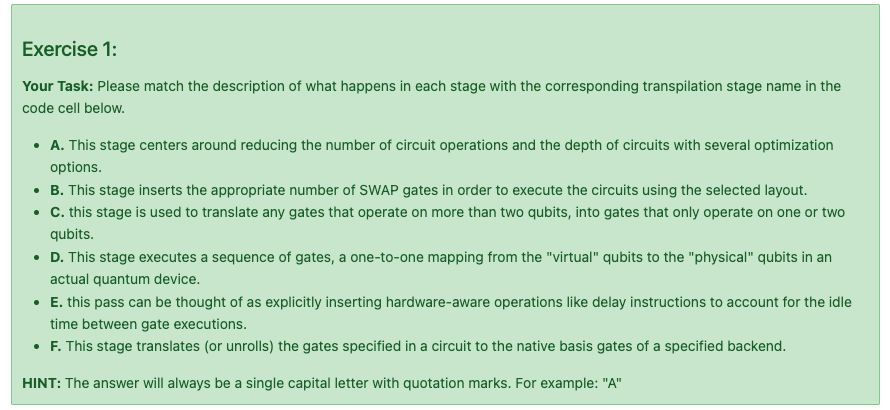

In [11]:
ans = {}

# Place the correct letter next to the corresponding stage, inside a parenthesis
# example:  ans["test"] = "M"

ans["init"] = "C"
ans["layout"] = "D"
ans["routing"] = "B"
ans["translation"] = "F"
ans["optimization"] = "A"
ans["scheduling"] = "E"


In [12]:
# Submit your answer using following code

grade_lab2_ex1(ans)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## Transpile with preset pass managers
In this part, we will explore how to use Qiskit's standard six transpiler stages. We will focus first on the four pre-defined transpile pipelines, and see how to build your own PassManager through a practice that uses the features and options of each pass with a pre-defined pipeline.

First, let's look at what Passmanager and generate_preset_pass_manager are. This part and later parts refers frequently to the IBM Quantum Platform docs and the API reference documentation on the transpiler, so we recommend you look at them together.

## What is a (staged) pass manager?
A pass manager is an object that stores a list of transpiler passes and can execute them on a circuit. You can create a pass manager by initializing a PassManager with a list of transpiler passes. To run the transpilation on a circuit, call the run method with a circuit as input.

A staged pass manager, represented by the StagedPassManager class, is a special kind of pass manager that represents a level of abstraction above that of a normal pass manager. While a normal pass manager is composed of several transpiler passes, a staged pass manager is composed of several pass managers. This is a useful abstraction because transpilation typically happens in discrete stages, with each stage being represented by a pass manager.

## Preset Passmanagers
Preset Passmanagers (qiskit.transpiler.preset_passmanagers) contains functions for generating the preset pass managers for transpiling. The preset pass managers are instances of StagedPassManager, which are used to execute the circuit transformations at the different optimization levels in the pre-defined transpiling pipeline. Here we introduce the functions used to generate the entire pass manager by using generate_preset_pass_manager.

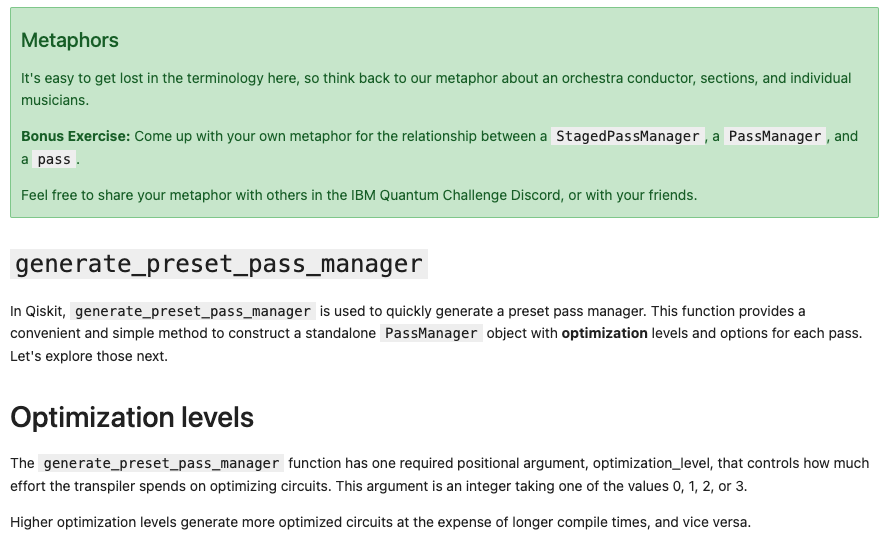

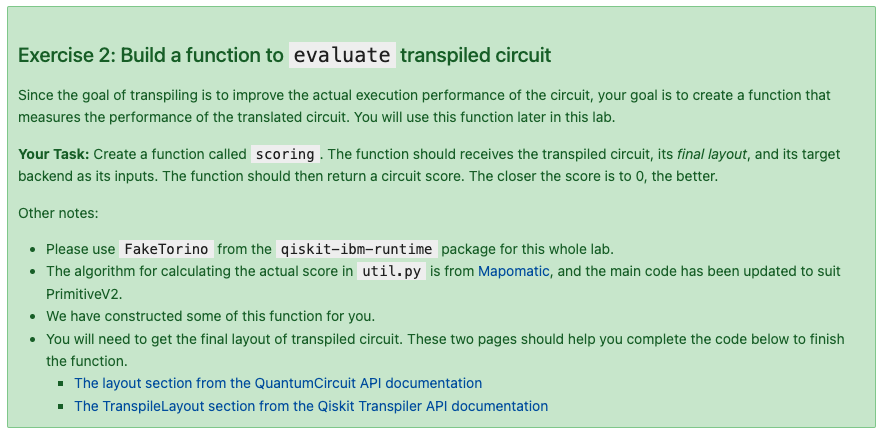

In [17]:
def transpile_scoring(circ, layout, backend):

    """
    A custom cost function that includes T1 and T2 computed during idle periods

    Parameters:
        circ (QuantumCircuit): circuit of interest
        layouts (list of lists): List of specified layouts
        backend (IBMQBackend): An IBM Quantum backend instance

    Returns:
        float: Fidelity of circ
    """

    fid = 1

    touched = set()
    dt = backend.dt
    num_qubits = backend.num_qubits

    error=0

    t1s = [backend.qubit_properties(qq).t1 for qq in range(num_qubits)]
    t2s = [backend.qubit_properties(qq).t2 for qq in range(num_qubits)]


    for item in circ._data:
        for gate in backend.operation_names:
            if item[0].name == gate:
                if (item[0].name == 'cz') or (item[0].name == 'ecr'):
                    q0 = circ.find_bit(item[1][0]).index
                    q1 = circ.find_bit(item[1][1]).index
                    fid *= 1 - backend.target[item[0].name][(q0, q1)].error
                    touched.add(q0)
                    touched.add(q1)
                elif item[0].name == 'measure':
                    q0 = circ.find_bit(item[1][0]).index
                    fid *= 1 - backend.target[item[0].name][(q0, )].error
                    touched.add(q0)

                elif item[0].name == 'delay':
                    q0 = circ.find_bit(item[1][0]).index
                    # Ignore delays that occur before gates
                    # This assumes you are in ground state and errors
                    # do not occur.
                    if q0 in touched:
                        time = item[0].duration * dt
                        fid *= 1-qubit_error(time, t1s[q0], t2s[q0])
                else:
                    q0 = circ.find_bit(item[1][0]).index
                    fid *= 1 - backend.target[item[0].name][(q0, )].error
                    touched.add(q0)

    return fid

In [18]:
### Create the scoring function

def scoring( qc, backend):
    layout = qc._layout
    fidelity = transpile_scoring(qc, layout, backend)
    score = 1-fidelity

    return score

In [19]:
# Submit your answer using following code

grade_lab2_ex2(scoring)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


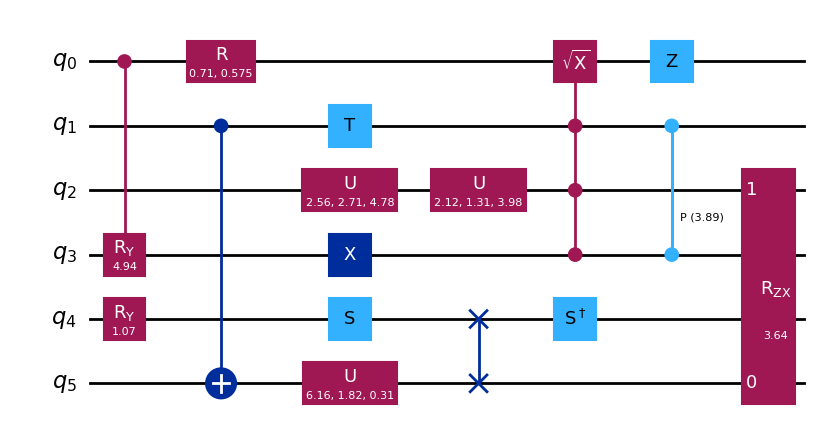

In [21]:
### Create a random circuit

## DO NOT CHANGE THE SEED NUMBER
seed = 10000

## Create circuit
num_qubits = 6
depth = 4
qc = random_circuit(num_qubits,depth,measure=False, seed=seed)

qc.draw('mpl')

Be careful!

*To pass the grader, do not change the seed values for seed or seed_transpiler throughout this whole lab*

In [22]:
## Save FakeTorino as backend

backend = FakeTorino()

In [24]:
# We are going to walk through running all four optimization levels and then compare our results at the end.
# In order to do this, we will create a few arrays to hold the information as we work, then use them later on.
circuit_depths = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}
gate_counts = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

scores = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

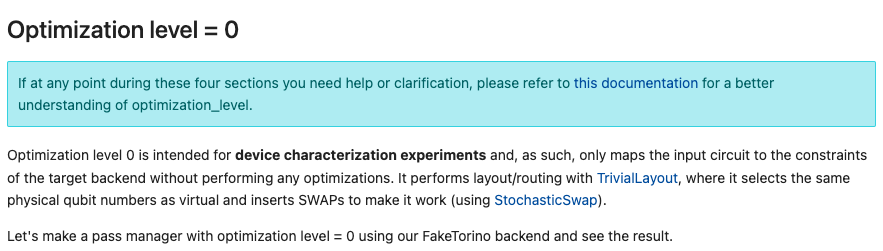

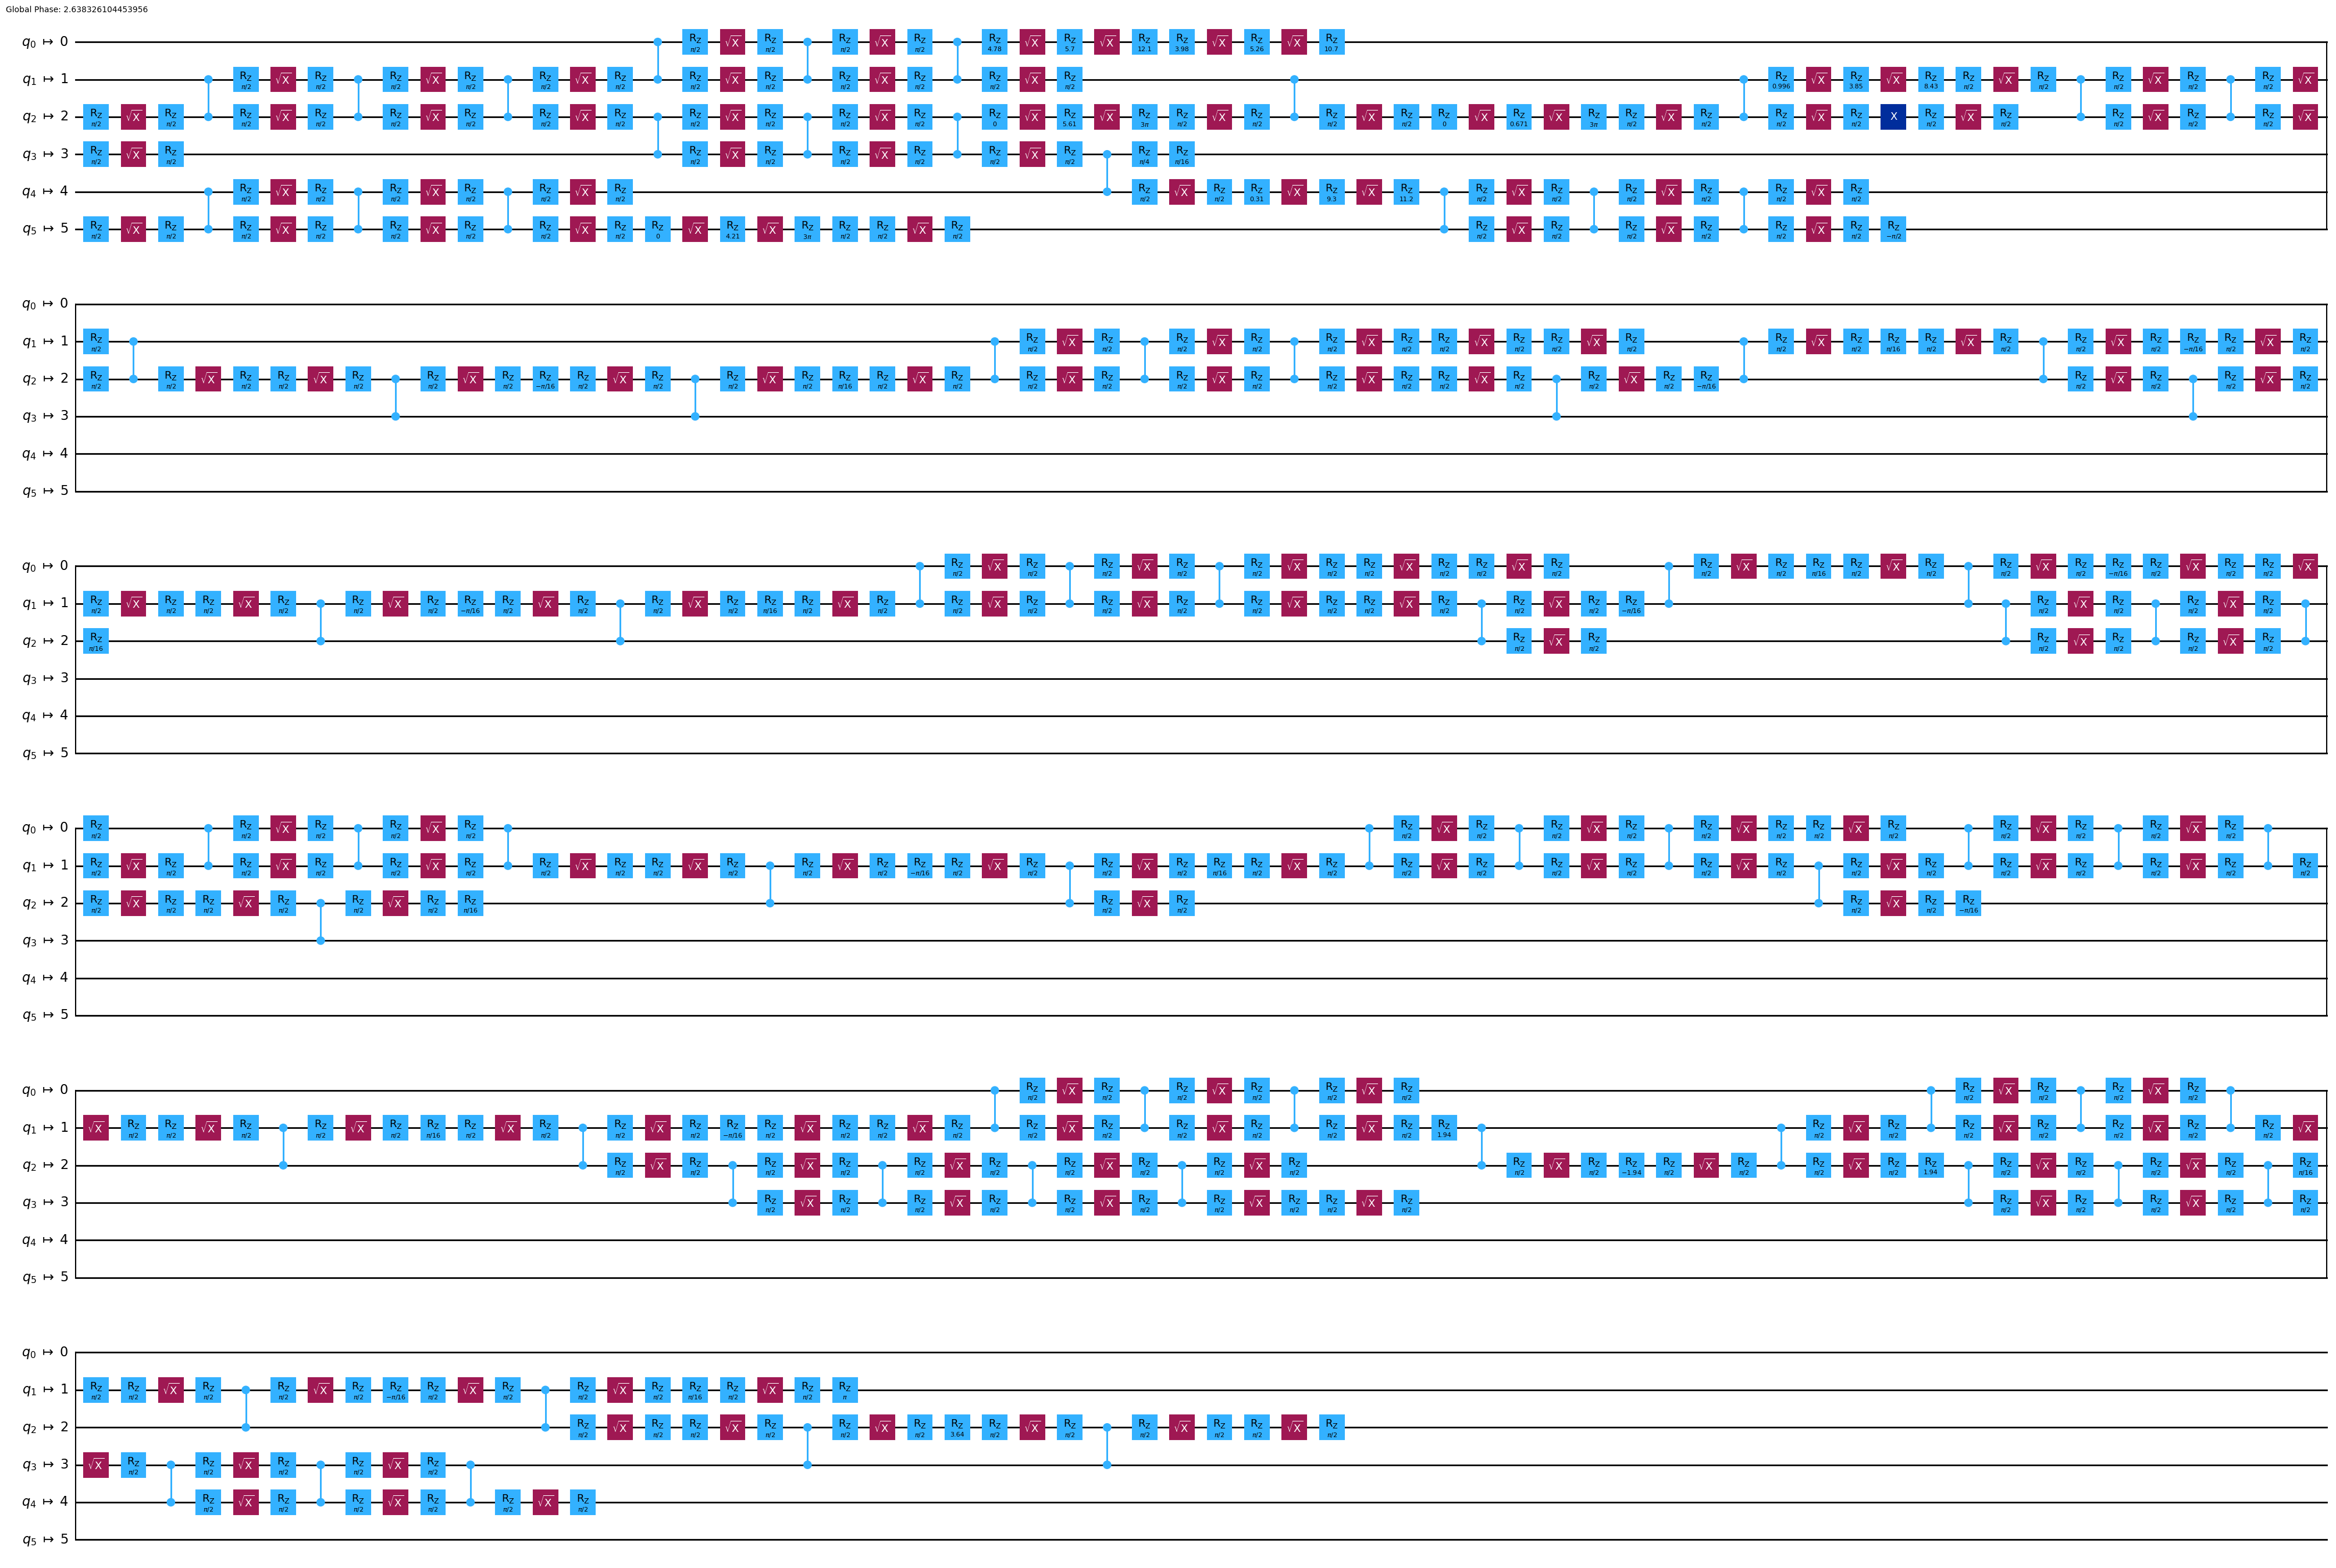

In [26]:
# Make a pass manager with our desired optimization level and backend
pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)

# Run for our random circuit
tr_lv0 = pm_lv0.run(qc)

# uncomment the next line to draw circuit
tr_lv0.draw('mpl', idle_wires=False, fold=60)

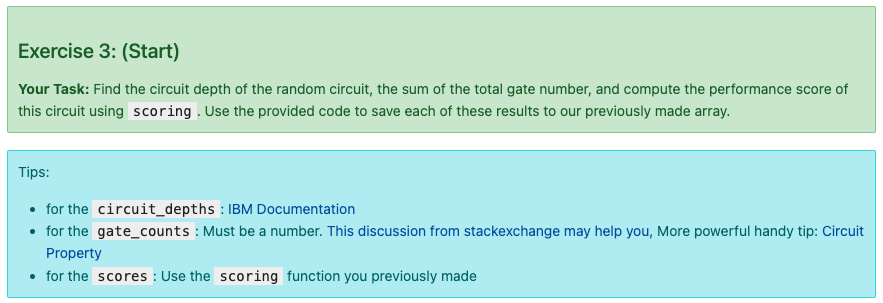

In [28]:
score_lv_0 = scoring(tr_lv0,backend)
score_lv_0

0.378009145088254

In [36]:
gate_lv_0 = dict(tr_lv0.count_ops())
print(gate_lv_0)
gate_count_lv_0 = sum(gate_lv_0.values())
print(gate_count_lv_0)

{'rz': 394, 'sx': 186, 'cz': 78, 'x': 1}
659


In [37]:
circuit_depth_lv_0 = tr_lv0.depth()
circuit_depth_lv_0

334

In [38]:
### Your code here ###

circuit_depths['opt_lv_0'] = circuit_depth_lv_0
gate_counts['opt_lv_0'] = gate_count_lv_0
scores['opt_lv_0'] = score_lv_0

### Don't change code after this line ###

print("Optimization level 0 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_0'])
print("Gate count:", gate_counts['opt_lv_0'])
print("Score:", scores['opt_lv_0'])

Optimization level 0 results
Circuit depth: 334
Gate count: 659
Score: 0.378009145088254


# Optimization level = 1
Optimization level 1 performs a light optimization. Here's what that means:

Layout/Routing: Layout is first attempted with TrivialLayout. If additional SWAPs are required, a layout with a minimum number of SWAPs is found by using SabreSWAP, then it uses VF2LayoutPostLayout` to try to select the best qubits in the graph.
InverseCancellation
1Q gate optimization
Try making a pass manager on your own this time. Once again use the FakeTorino backend with generate_preset_pass_manager. Please also set the optimization_level to 1, and seed_transpiler = seed

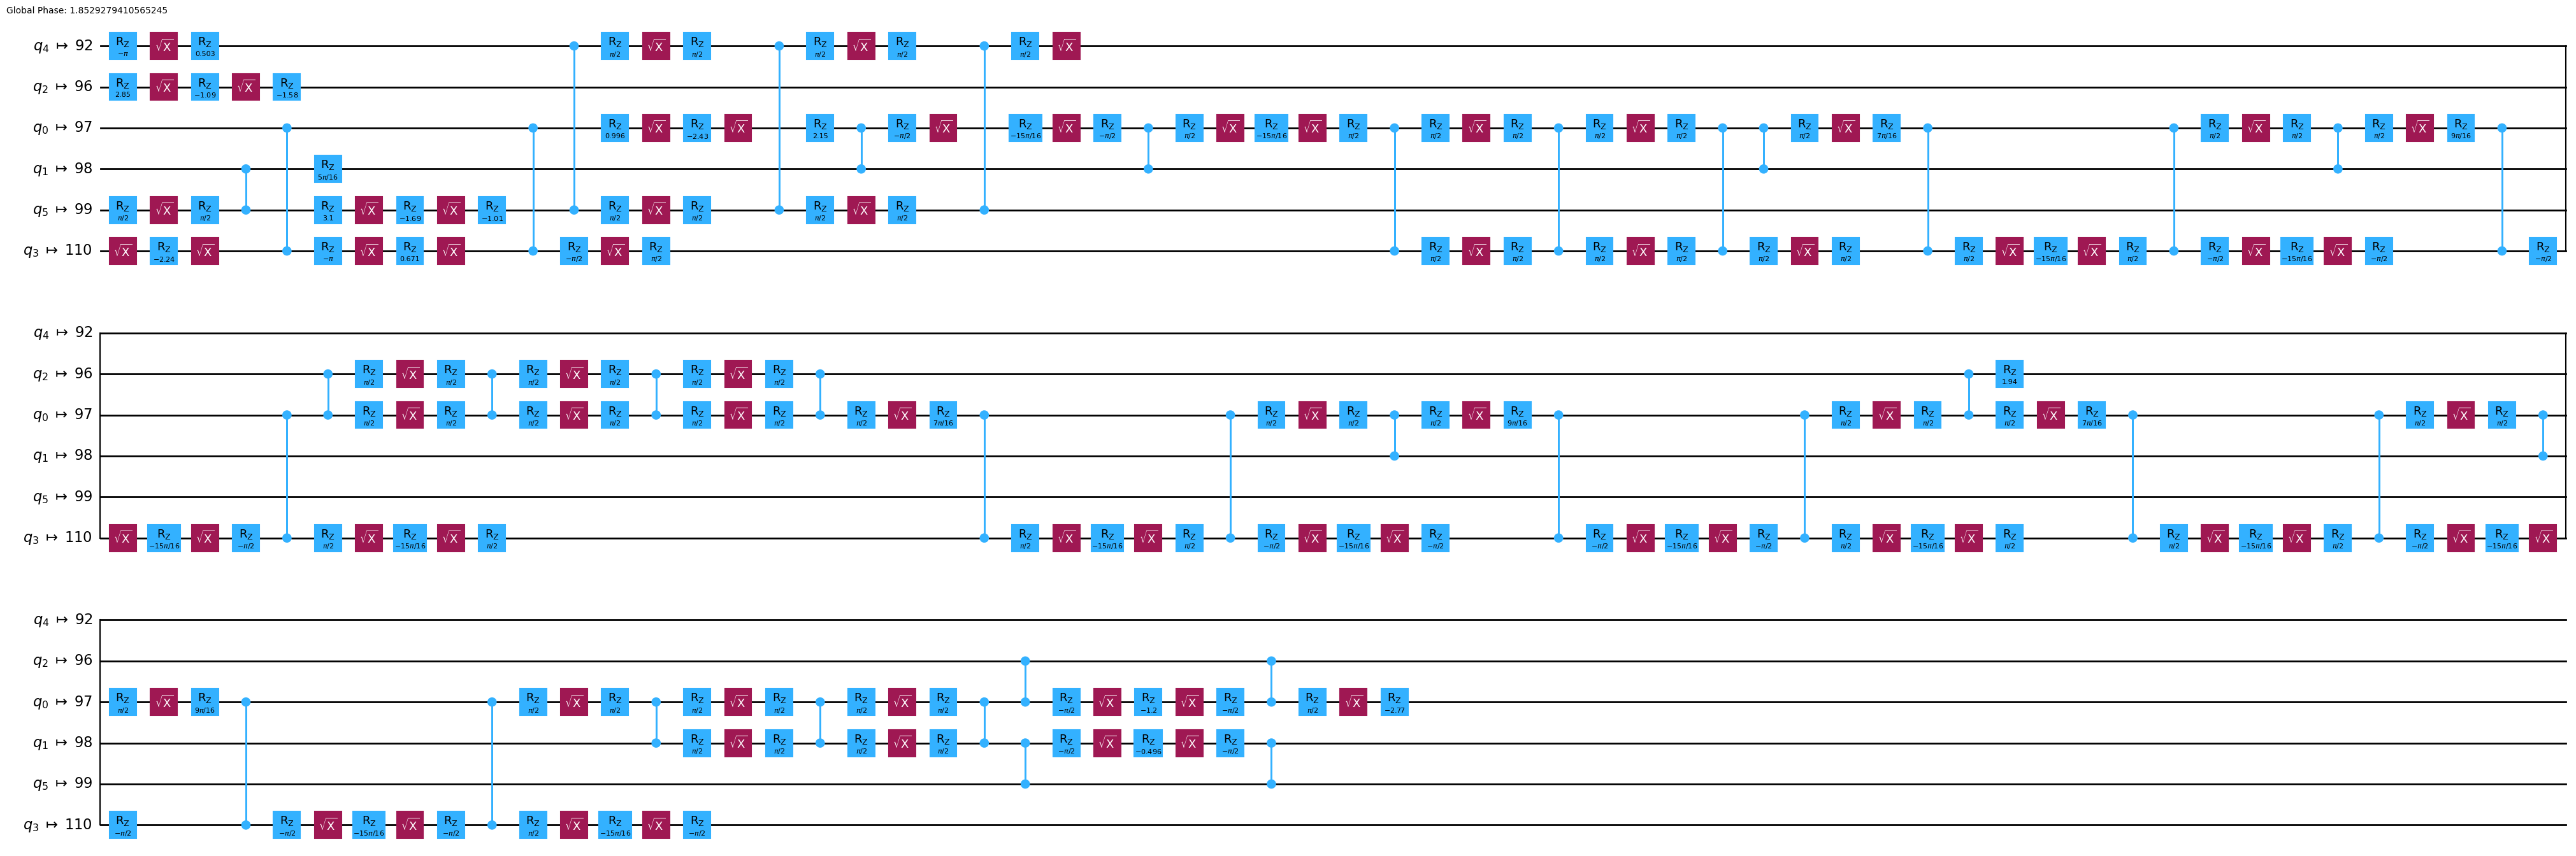

In [39]:
# Make a pass manager with our desired optimization level and backend
pm_lv1 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)


# Run for our random circuit
tr_lv1 = pm_lv1.run(qc)

# uncomment the next line to draw circuit
tr_lv1.draw('mpl', idle_wires=False, fold=60)

In [43]:
### Your code here ###

circuit_depths['opt_lv_1'] =tr_lv1.depth()
gate_counts['opt_lv_1'] =sum(dict(tr_lv1.count_ops()).values())
scores['opt_lv_1'] =scoring(tr_lv1,backend)

### Don't change code after this line ###

print("Optimization level 1 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_1'])
print("Gate count:", gate_counts['opt_lv_1'])
print("Score:", scores['opt_lv_1'])

Optimization level 1 results
Circuit depth: 147
Gate count: 247
Score: 0.10053438782707702


# Optimization level = 2
Optimization level 2 performs a medium optimization, which means:

Layout/Routing: Optimization level 1 (without trivial) + heuristic optimized with greater search depth and trials of optimization function. Because TrivialLayout is not used, there is no attempt to use the same physical and virtual qubit numbers.
CommutativeCancellation
Let's make a pass manager with optimization_level of 2 this time, again using generate_preset_pass_manager with the FakeTorino backend and seed_transpiler = seed.

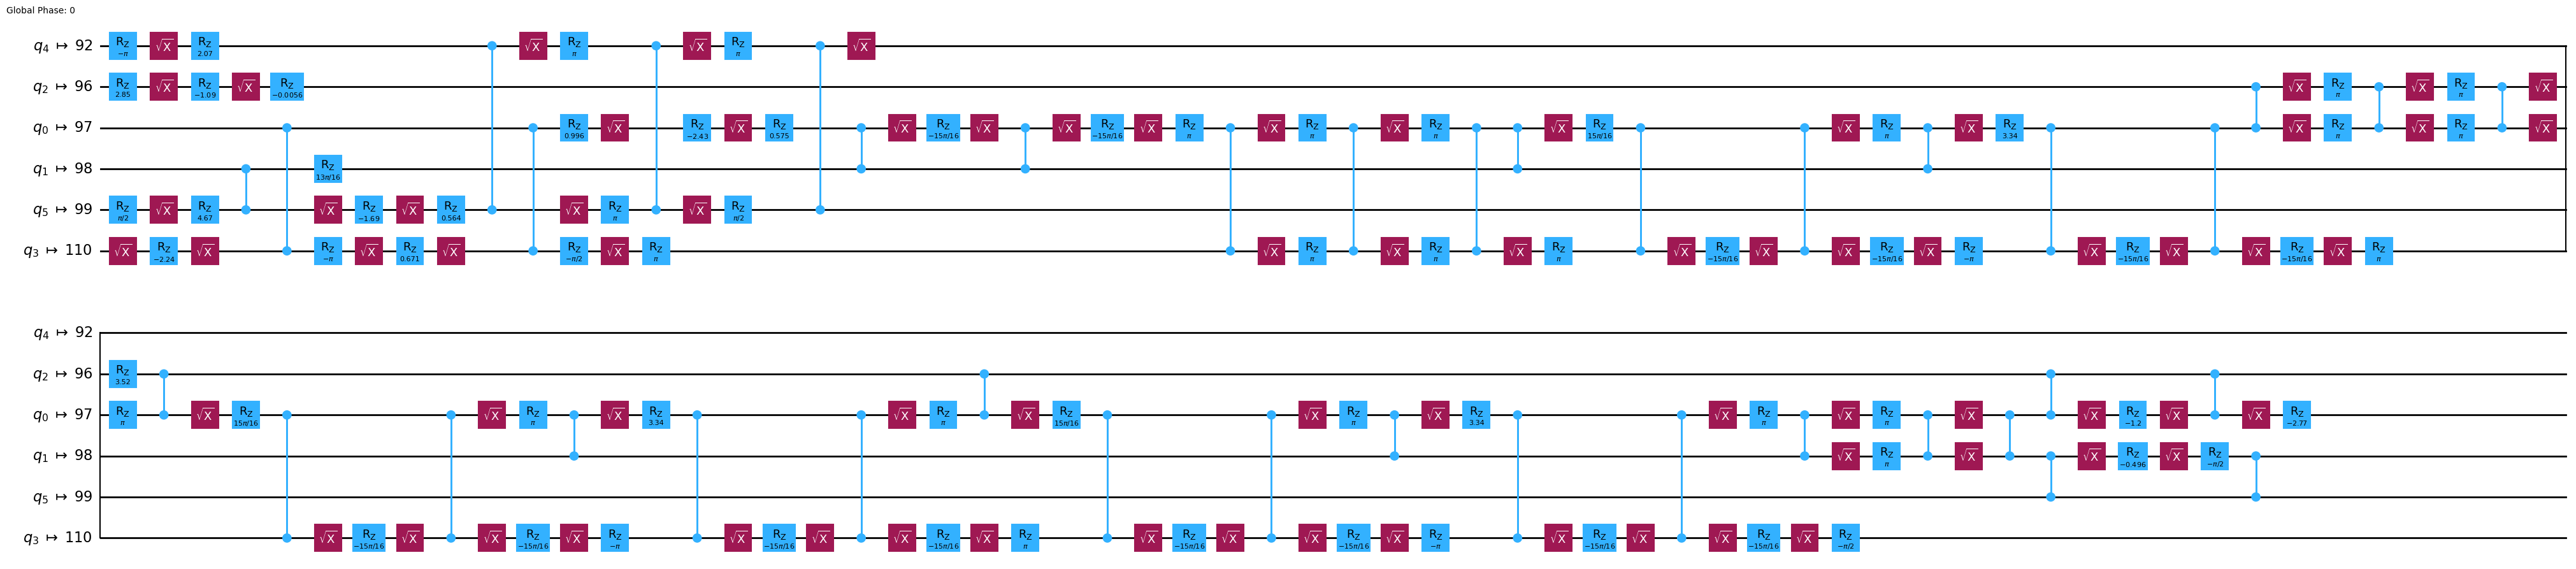

In [42]:
# Make a pass manager with our desired optimization level and backend
pm_lv2 = generate_preset_pass_manager(backend=backend, optimization_level=2, seed_transpiler=seed)

# Run for our random circuit
tr_lv2 = pm_lv2.run(qc)

# uncomment the next line to draw circuit
tr_lv2.draw('mpl', idle_wires=False, fold=60)

In [44]:
### Your code here ###

circuit_depths['opt_lv_2'] =tr_lv2.depth()
gate_counts['opt_lv_2'] =sum(dict(tr_lv2.count_ops()).values())
scores['opt_lv_2'] =scoring(tr_lv2,backend)

### Don't change code after this line ###

print("Optimization level 2 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_2'])
print("Gate count:", gate_counts['opt_lv_2'])
print("Score:", scores['opt_lv_2'])

Optimization level 2 results
Circuit depth: 110
Gate count: 187
Score: 0.10053438782707702


# Optimization level = 3
Optimization level 3 performs a high optimization:

Optimization level 2 + heuristic optimized on layout/routing further with greater effort/trials
Resynthesis of two-qubit blocks using Cartan's KAK Decomposition.
Unitarity-breaking passes: the classical bit of the measure instruction to avoid SWAPs

**OptimizeSwapBeforeMeasure**: Remove swaps in front of measurements by re-targeting


**RemoveDiagonalGatesBeforeMeasure**: Remove diagonal gates (like RZ, T, Z, etc.) before a measurement. Including diagonal 2Q gates.

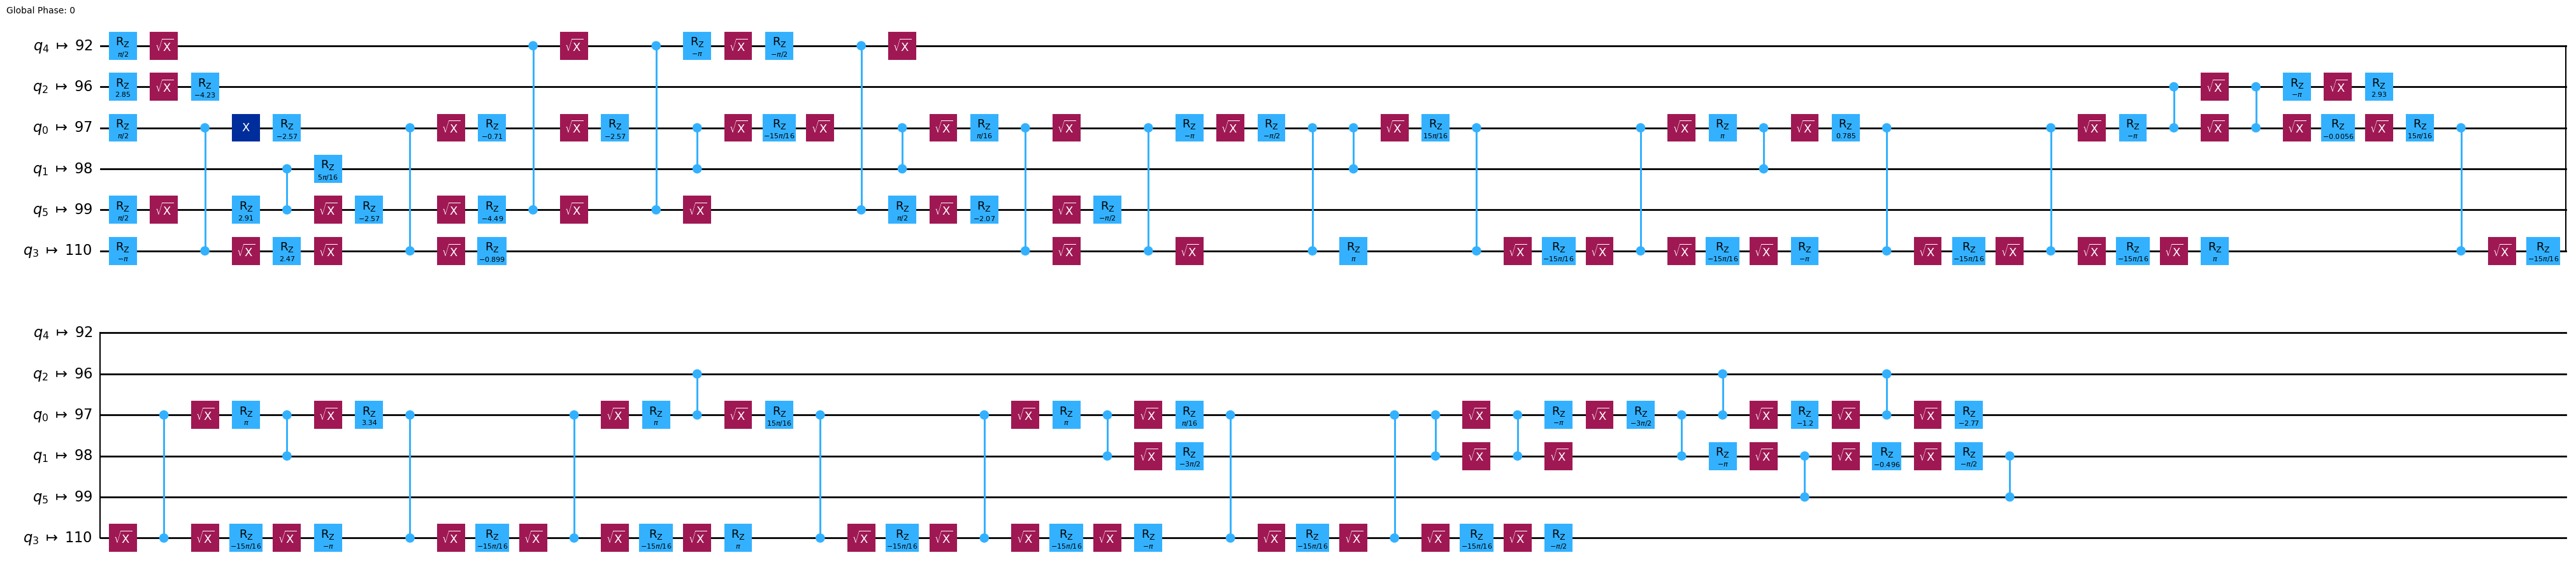

In [45]:
pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)

tr_lv3 = pm_lv3.run(qc)

# uncomment to draw circuit
tr_lv3.draw('mpl', idle_wires=False, fold=60)

In [46]:
### Your code here ###

circuit_depths['opt_lv_3'] =tr_lv3.depth()
gate_counts['opt_lv_3'] =sum(dict(tr_lv3.count_ops()).values())
scores['opt_lv_3'] =scoring(tr_lv3,backend)

### Don't change code after this line ###

print("Optimization level 3 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_3'])
print("Gate count:", gate_counts['opt_lv_3'])
print("Score:", scores['opt_lv_3'])

Optimization level 3 results
Circuit depth: 101
Gate count: 177
Score: 0.09612632219732442


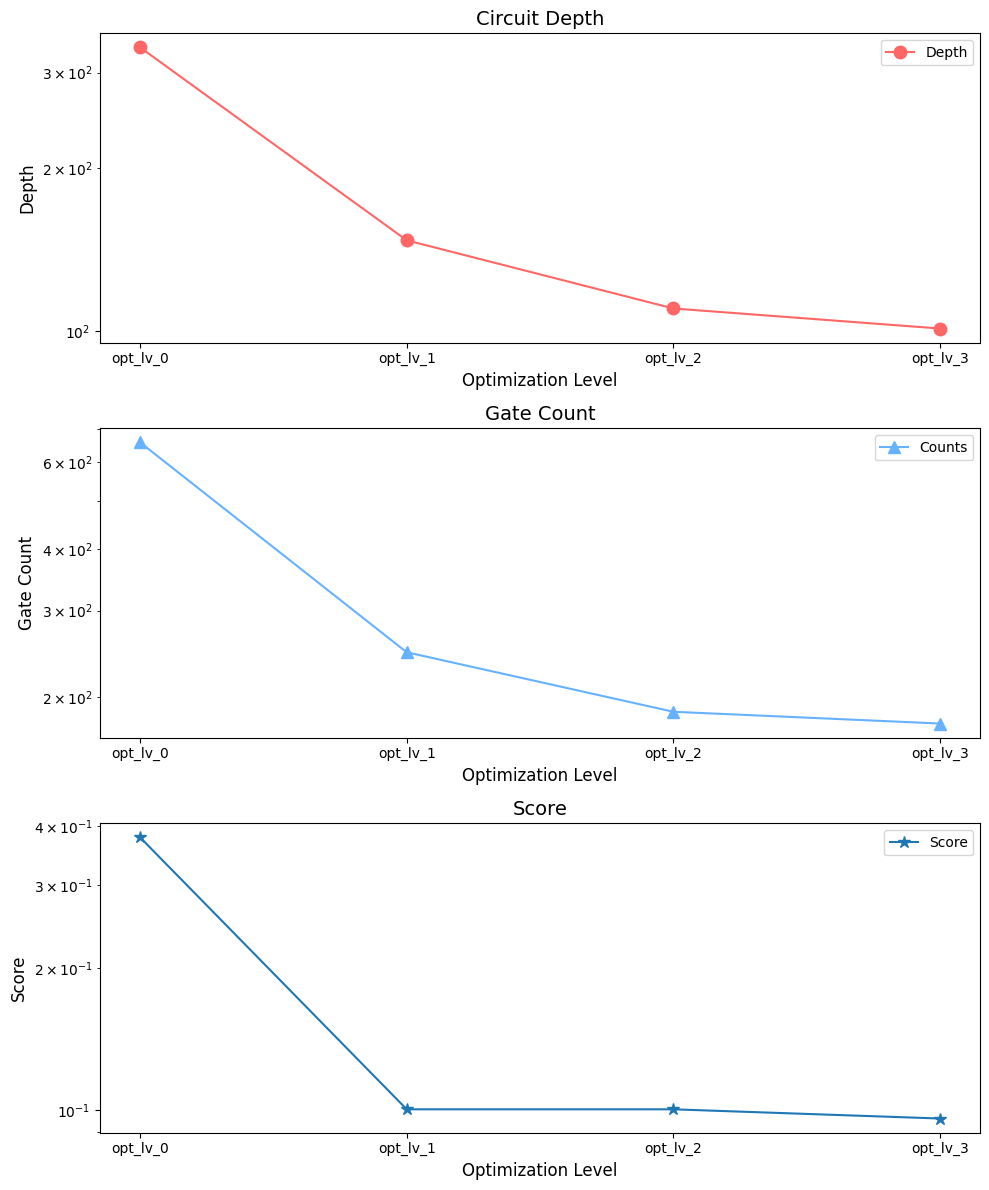

In [47]:
colors = ['#FF6666', '#66B2FF']
ax = ["opt_lv_0", "opt_lv_1", "opt_lv_2", "opt_lv_3"]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
ax1.semilogy(ax, [circuit_depths[key] for key in ax],'o-',markersize=9, color='#FF6666', label="Depth")
ax1.set_xlabel("Optimization Level", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
ax2.semilogy(ax, [gate_counts[key] for key in ax],'^-',markersize=9, color='#66B2FF', label="Counts")
ax2.set_xlabel("Optimization Level", fontsize=12)
ax2.set_ylabel("Gate Count", fontsize=12)
ax2.set_title("Gate Count", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
ax3.semilogy(ax, [scores[key] for key in ax],'*-',markersize=9, label="Score")
ax3.set_xlabel("Optimization Level", fontsize=12)
ax3.set_ylabel("Score", fontsize=12)
ax3.set_title("Score", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

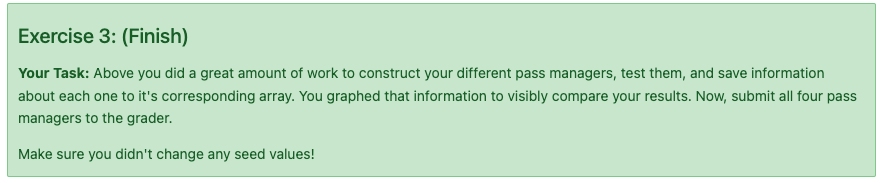

In [52]:
# Submit your answer using following code

ans = [pm_lv0, pm_lv1, pm_lv2, pm_lv3]

grade_lab2_ex3(ans)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


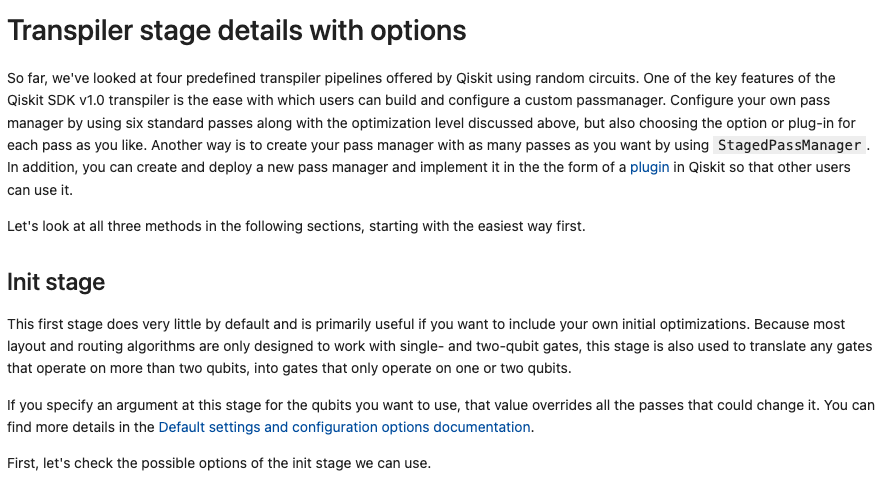

In [49]:
list_stage_plugins("init")

['default']

Without extra plugins, only default options exist. This process includes several transpiler pass plugins depending on the optimization_level - let's take a look inside it.

For this, let's create a pass manager with init_method="default" option

In [51]:
print("Plugins run by default init stage")
print("=================================")

for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, init_method="default", seed_transpiler=1000)
    for task in pm.init.to_flow_controller().tasks:
        print(" -", type(task).__name__)

Plugins run by default init stage

Optimization level 0:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator

Optimization level 1:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - InverseCancellation

Optimization level 2:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - InverseCancellation

Optimization level 3:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - OptimizeSwapBeforeMeasure
 - RemoveDiagonalGatesBeforeMeasure
 - InverseCancellation


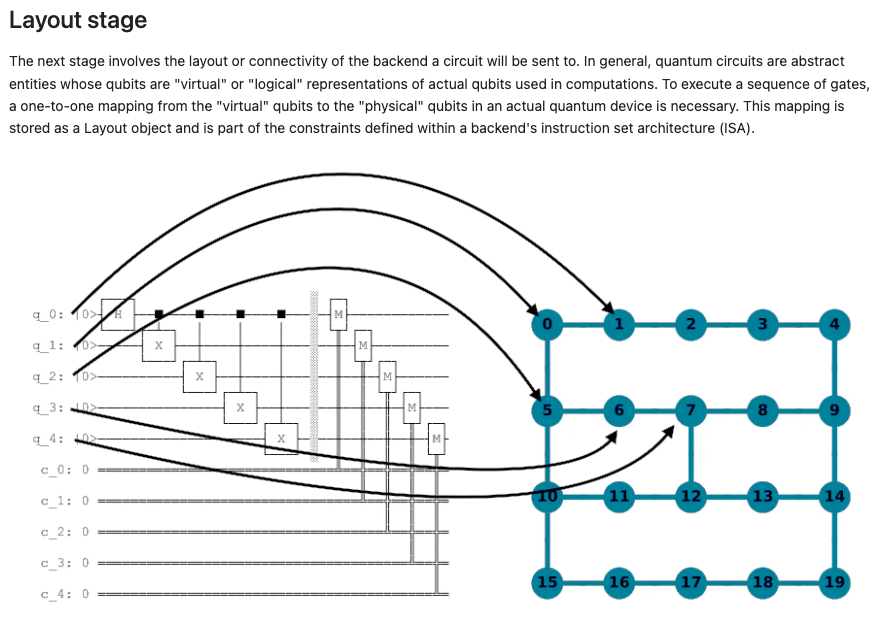

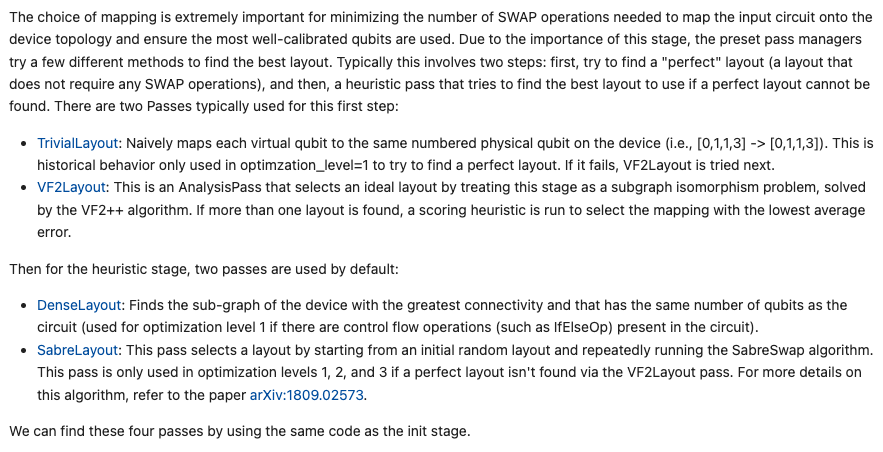

In [53]:
list_stage_plugins("layout")

['default', 'dense', 'sabre', 'trivial']

Plugins run by default layout stage

Optimization level 0:
 -  TrivialLayout
[1, 4, 2, 0, 5, 3]


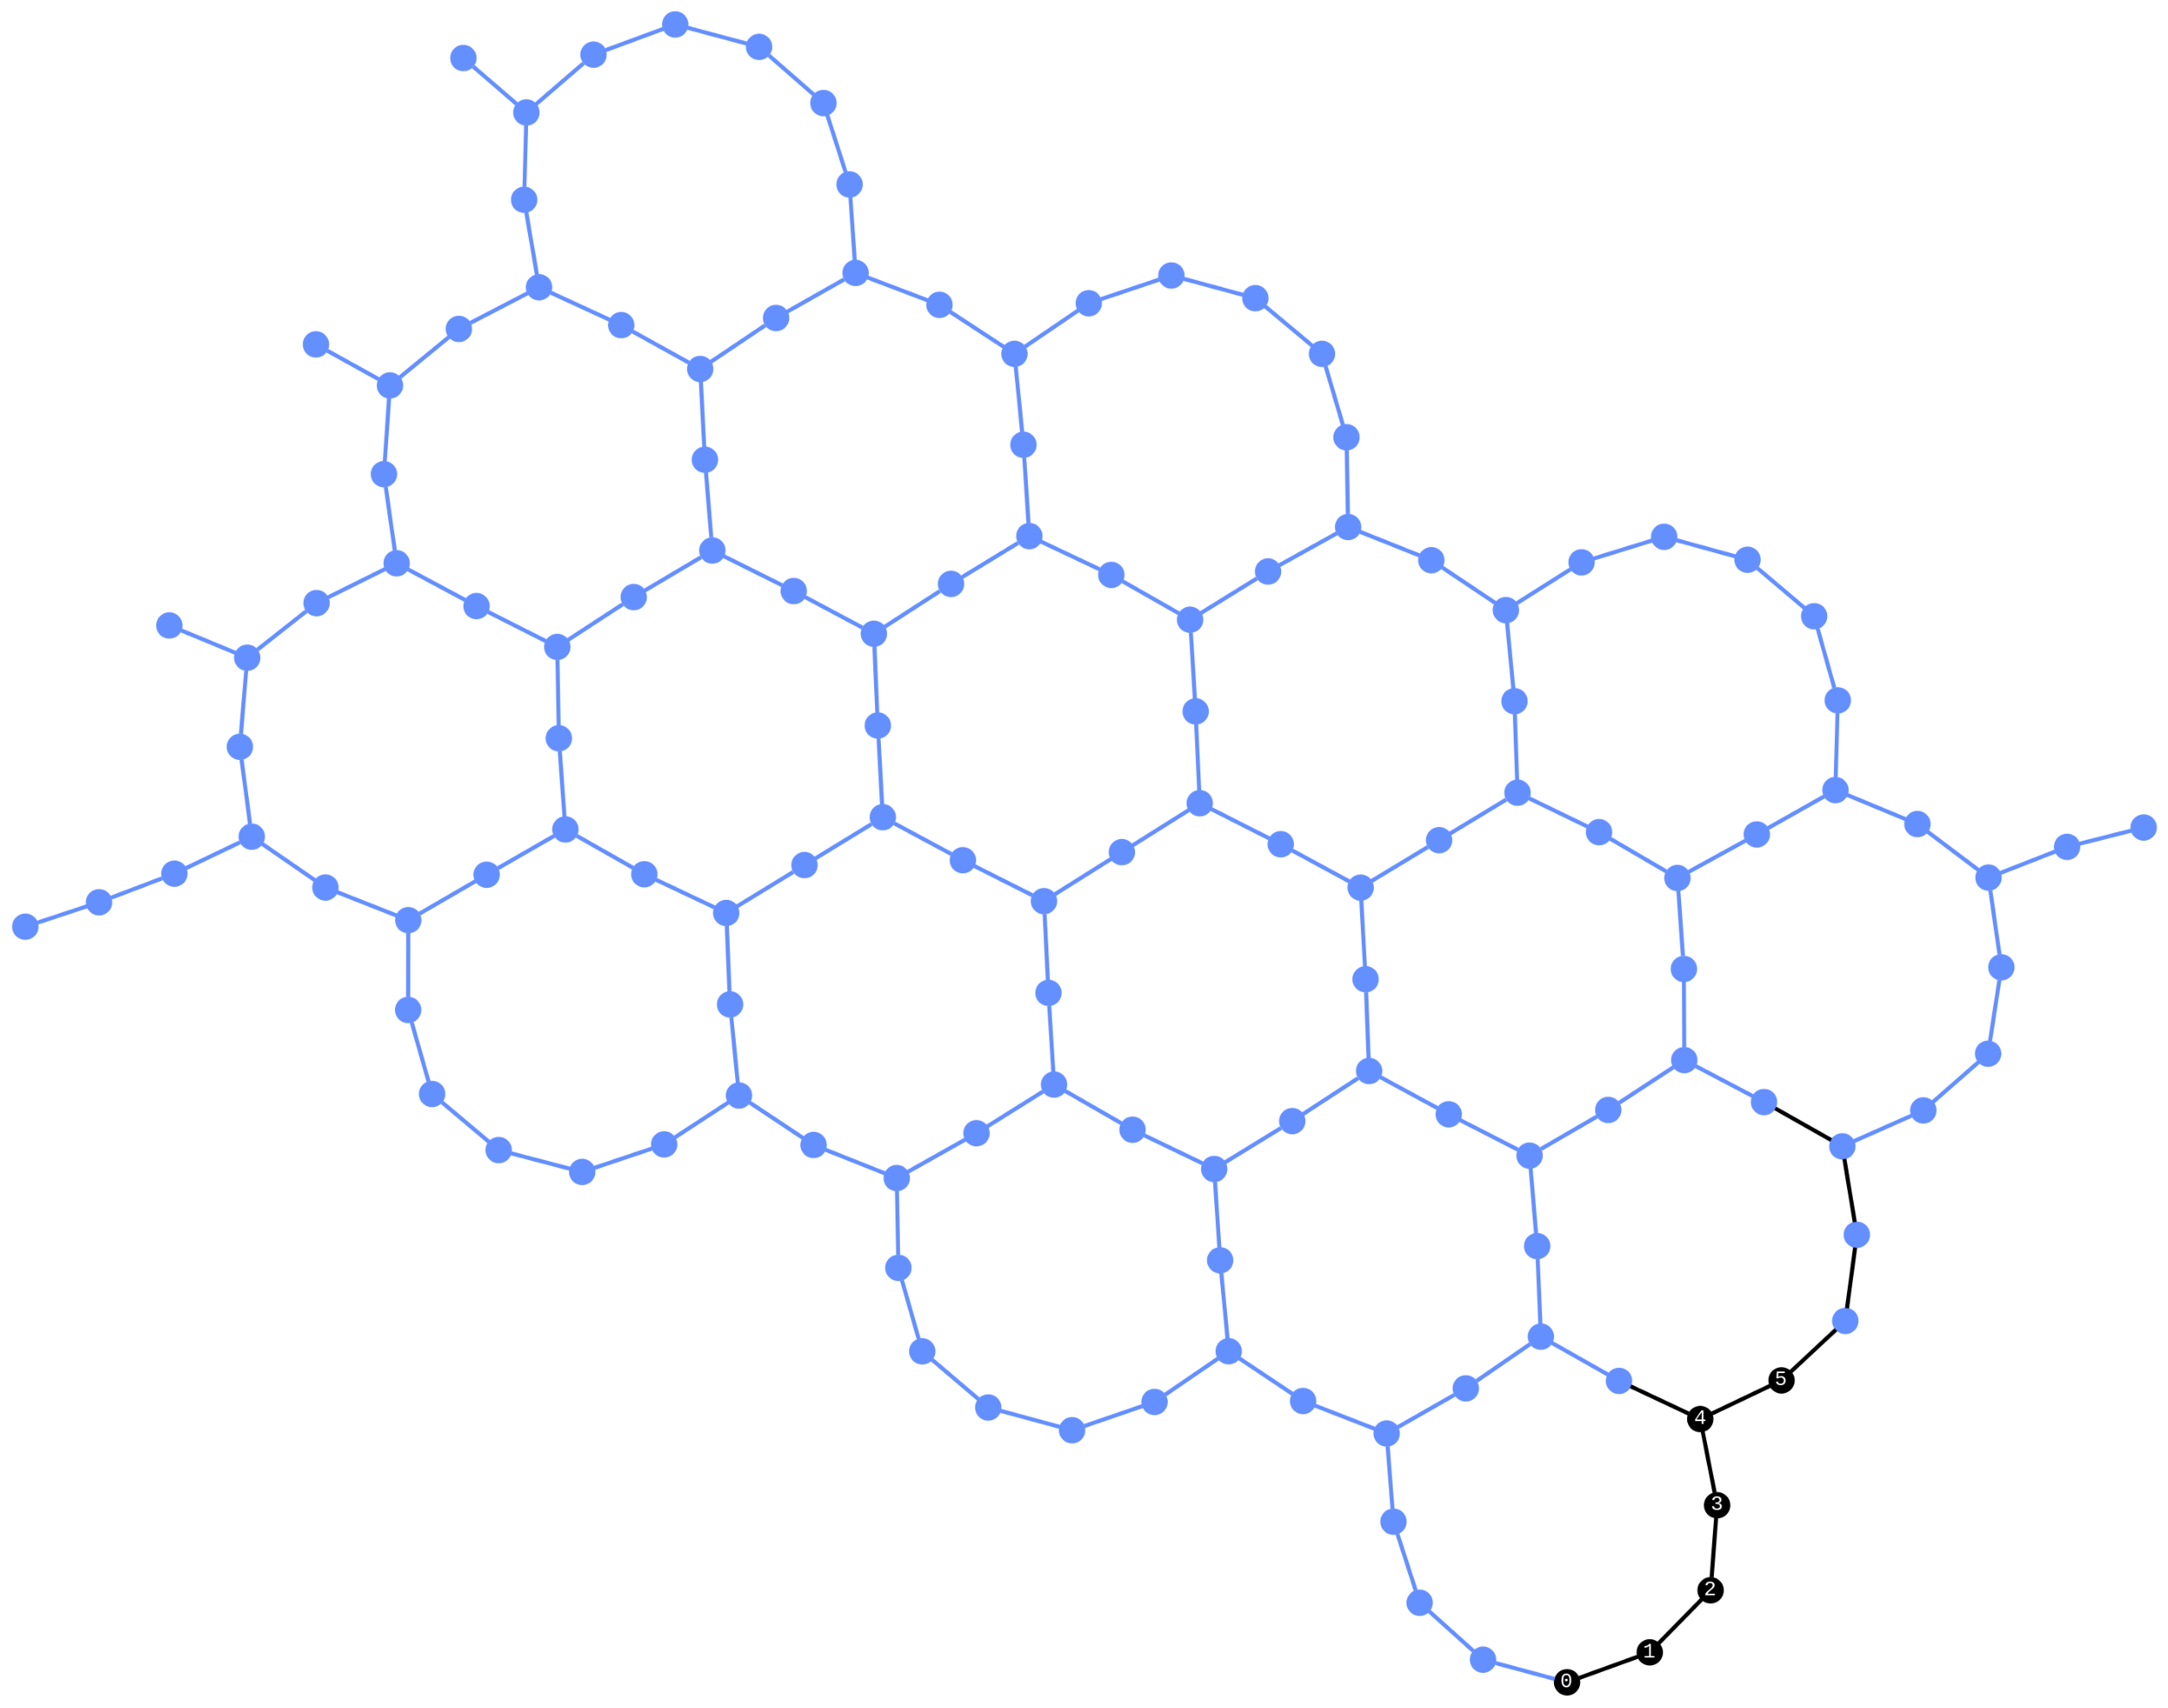


Optimization level 1:
 -  TrivialLayout
 -  CheckMap
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[85, 84, 83, 93, 73, 82]


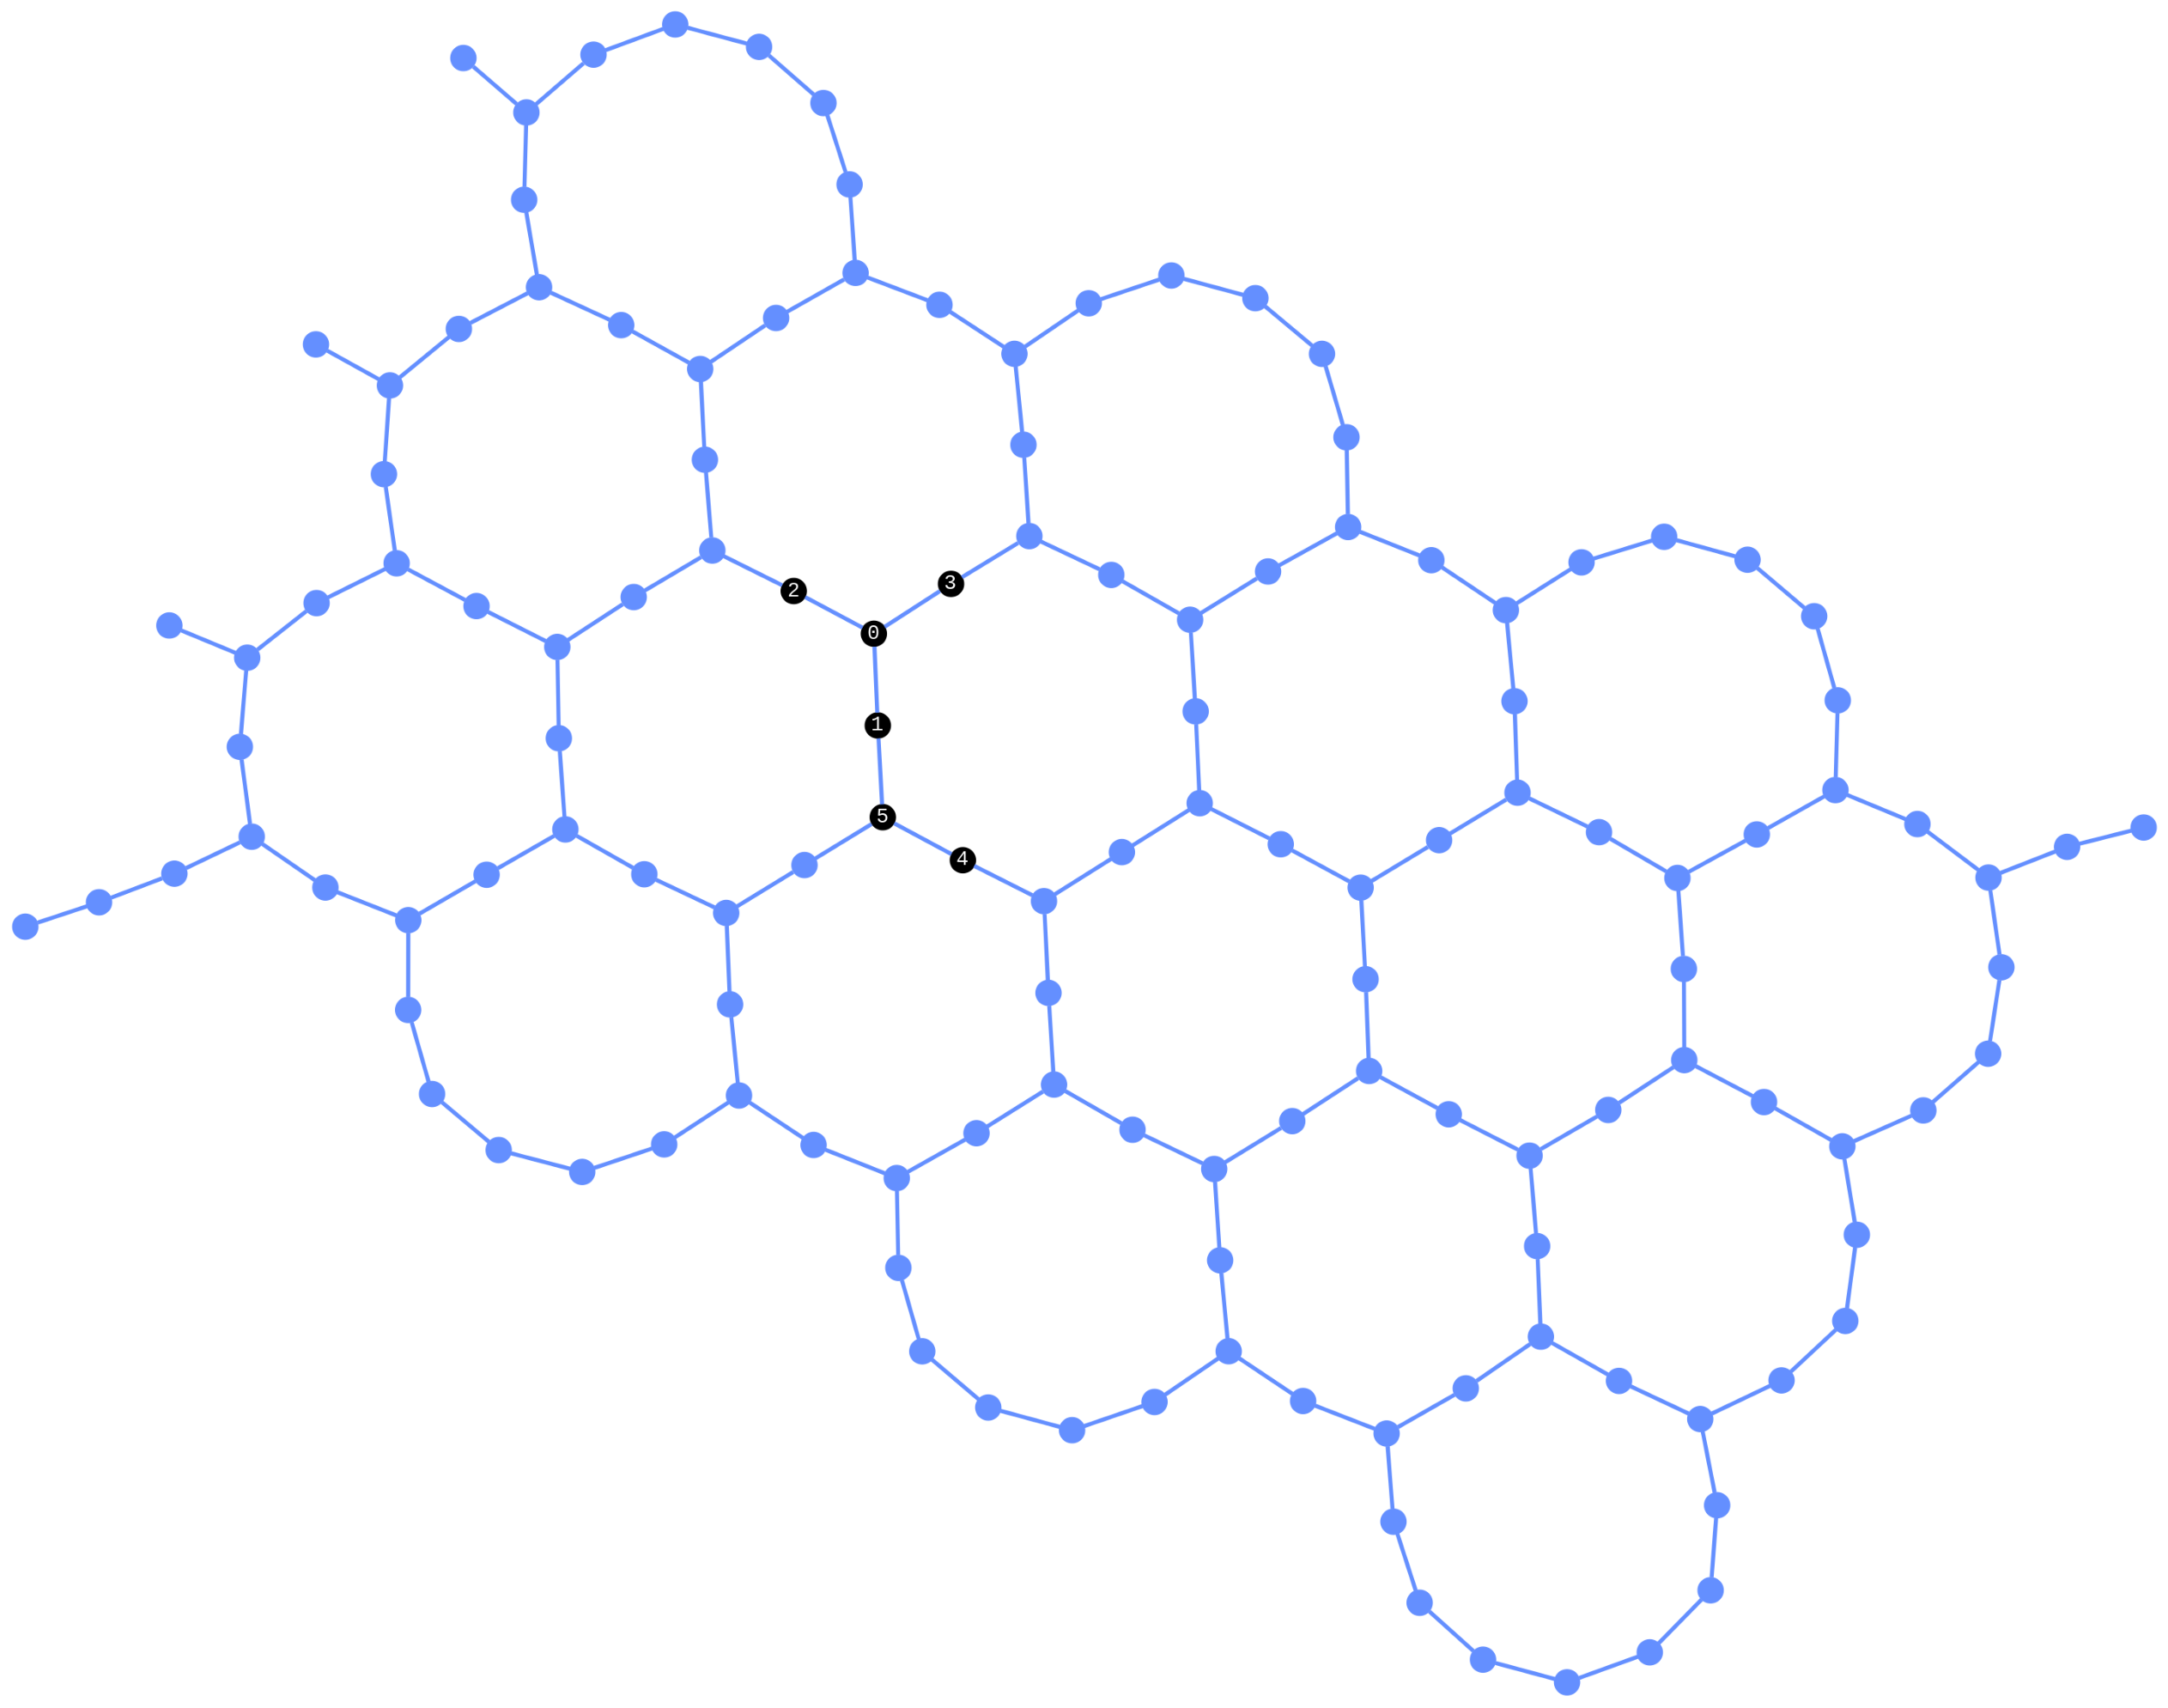


Optimization level 2:
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[85, 84, 83, 93, 73, 82]


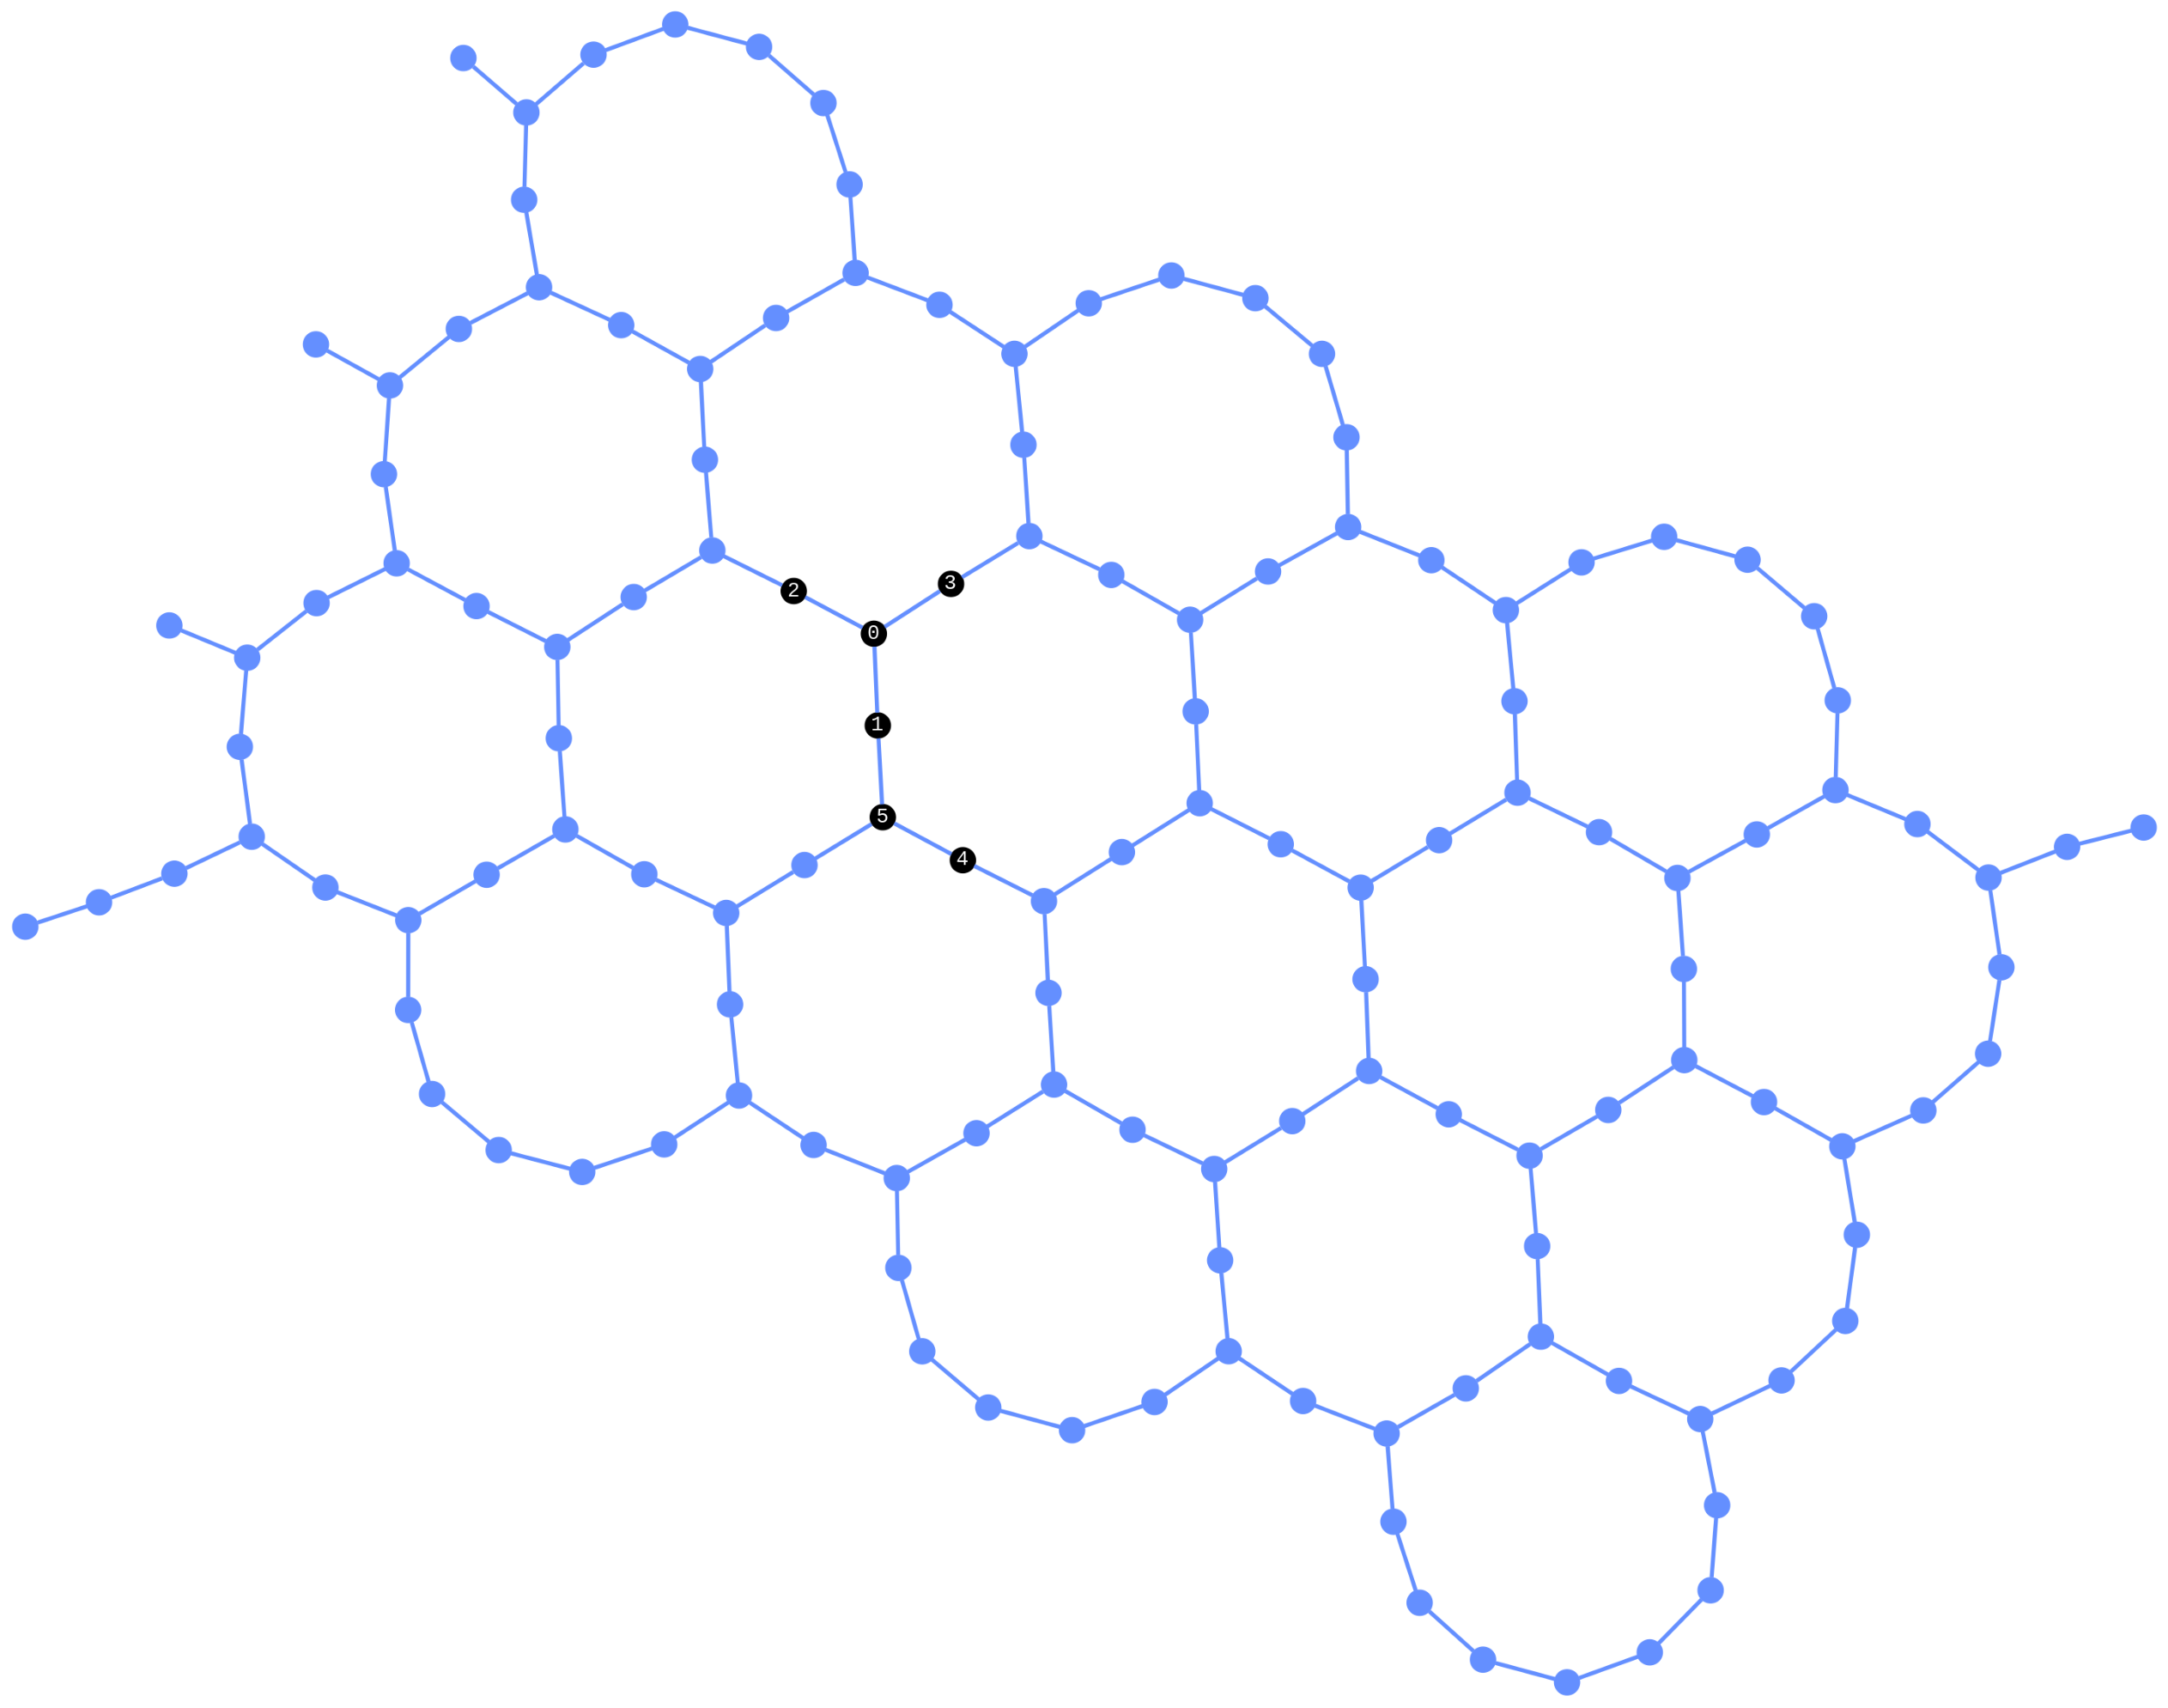


Optimization level 3:
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[85, 84, 83, 93, 73, 82]


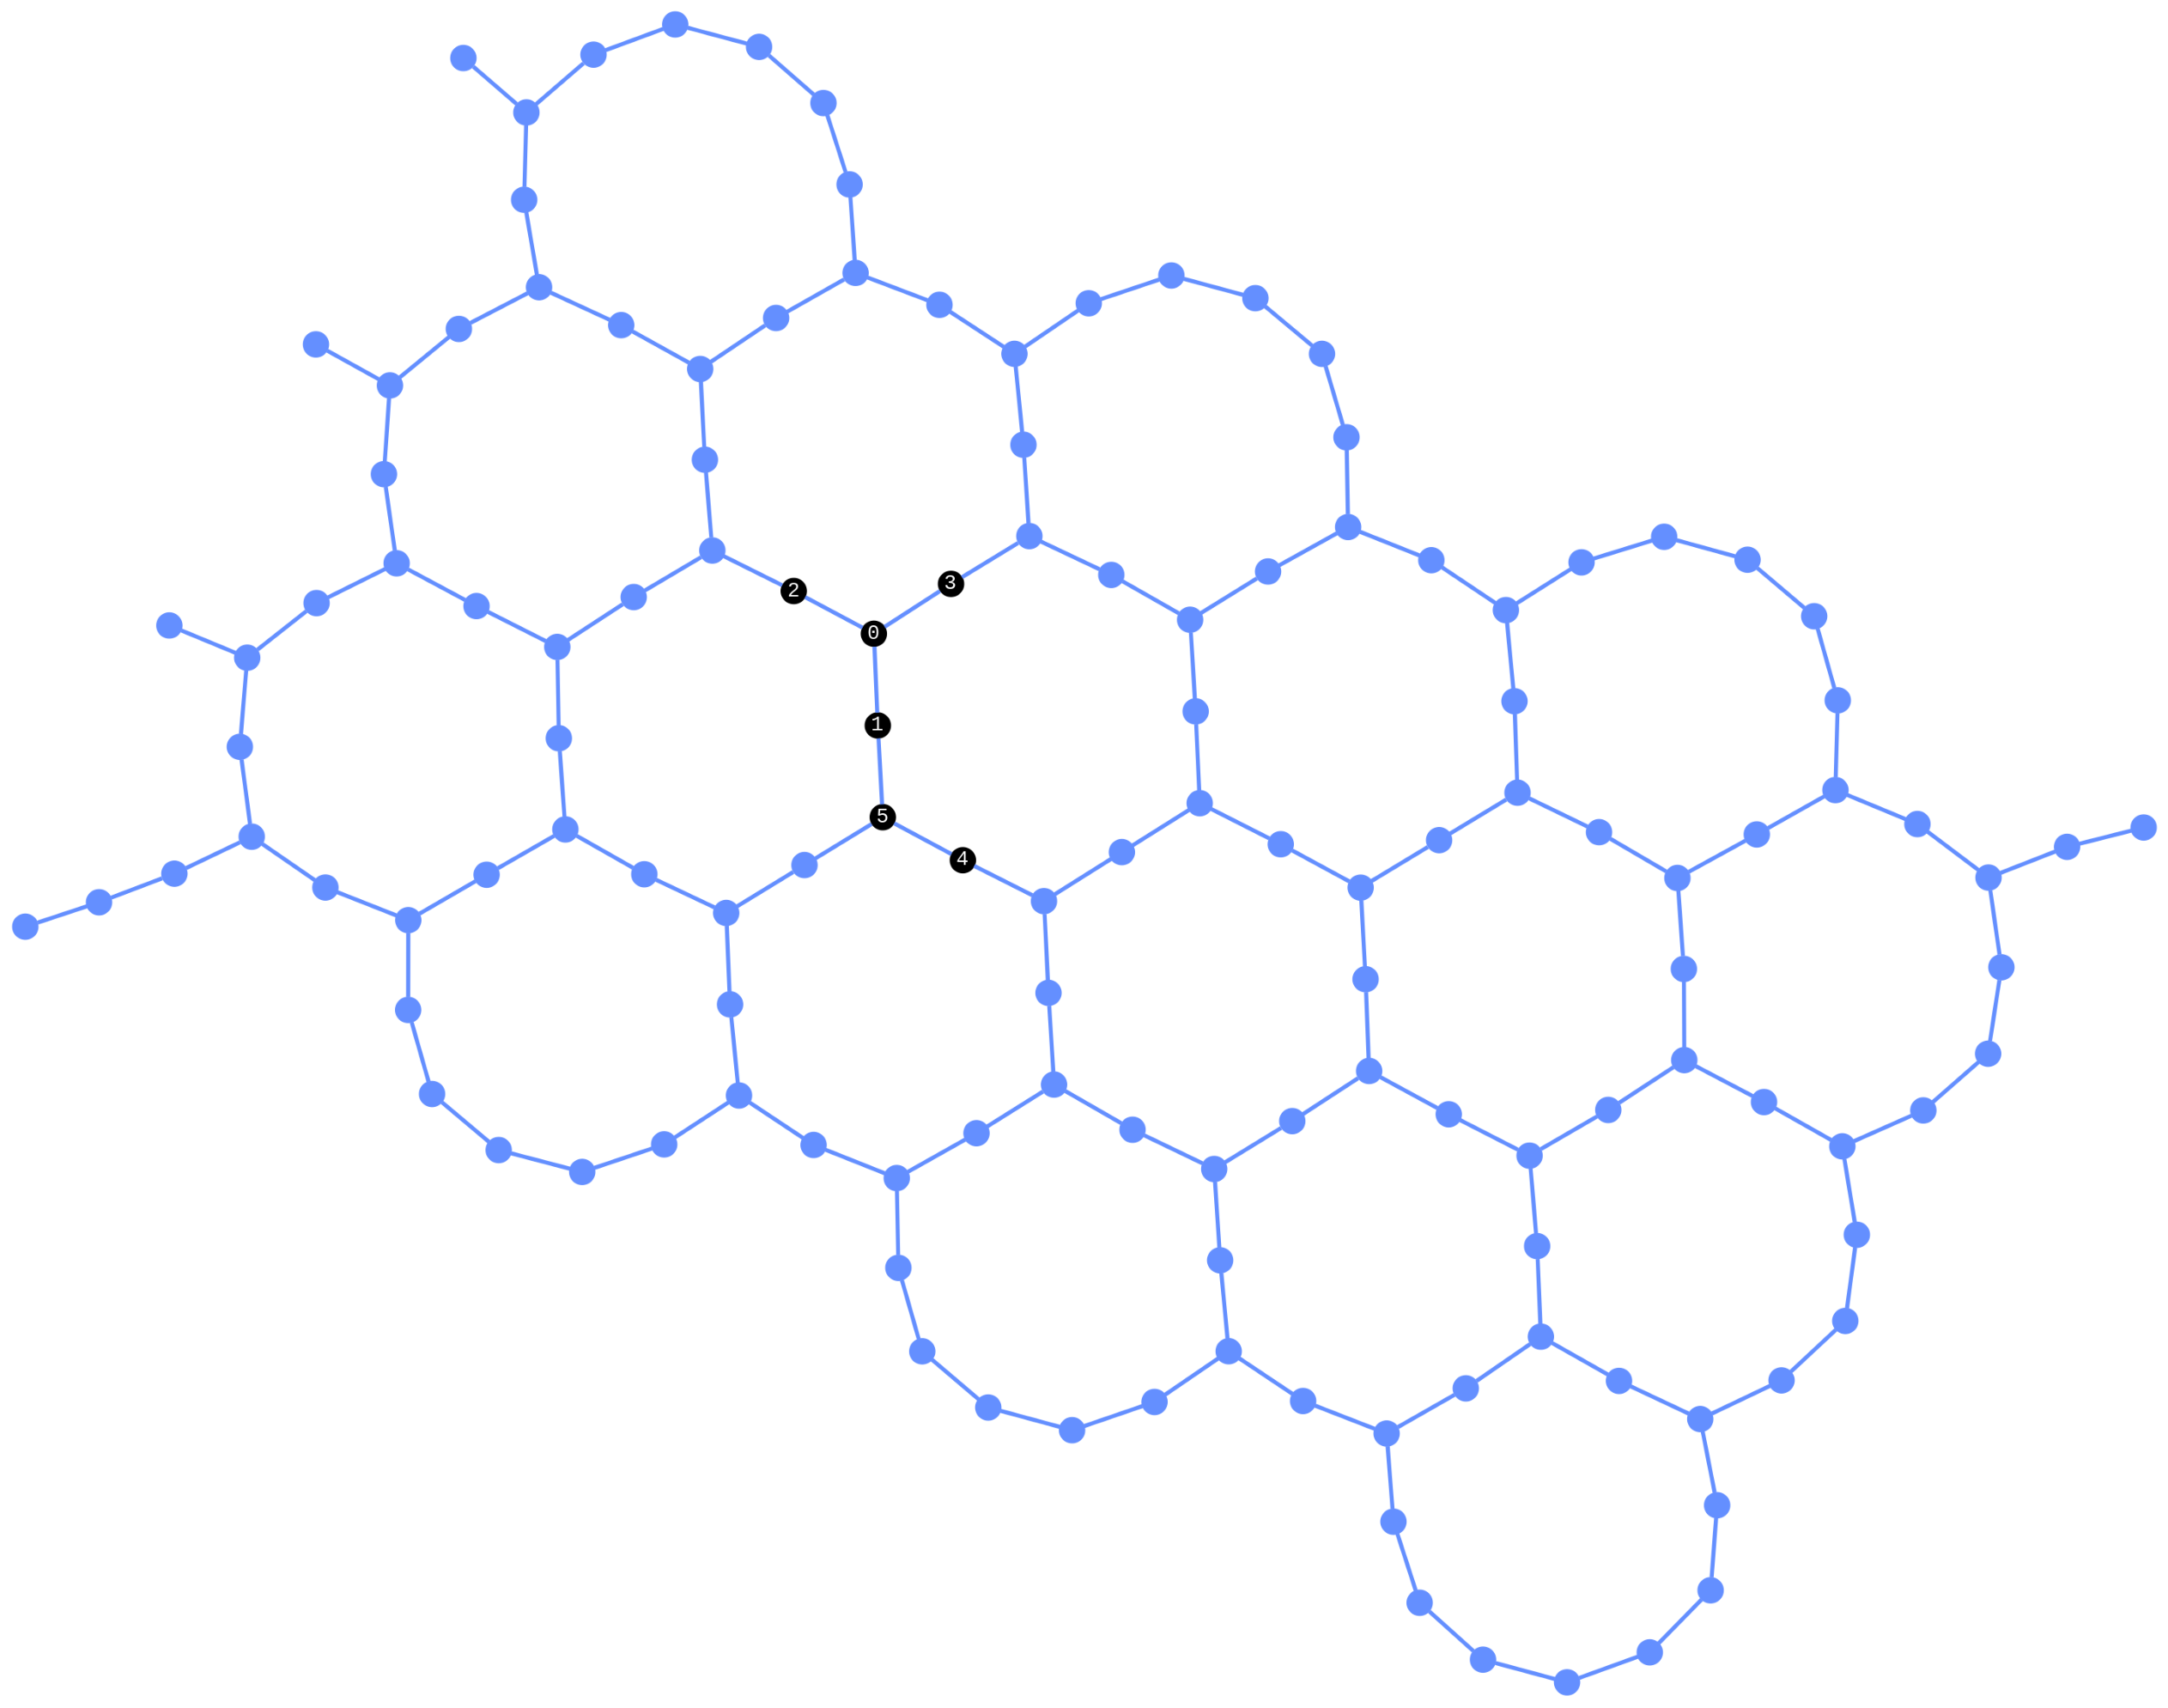

In [54]:
print("Plugins run by default layout stage")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, layout_method='default', seed_transpiler=seed)
    qc_tr = pm.run(qc)

    for controller_group in pm.layout.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:
            print(" - " , str(type(task).__name__))
    print(qc_tr.layout.final_index_layout())
    display(plot_circuit_layout(pm.run(qc), backend))

In [55]:
# Now let's compare the score and layout of each option with optimization_level=3.

for option in list_stage_plugins("layout"):
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, layout_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)

    print(f"Layout method = {option}")
    print(f"Score: {score:.6f}")
    print(f"Layout: {qc_tr.layout.final_index_layout()}\n")

Layout method = default
Score: 0.276088
Layout: [85, 84, 83, 93, 73, 82]

Layout method = dense
Score: 0.189147
Layout: [37, 52, 51, 49, 56, 50]

Layout method = sabre
Score: 0.276088
Layout: [85, 84, 83, 93, 73, 82]

Layout method = trivial
Score: 0.334350
Layout: [0, 1, 2, 4, 5, 3]



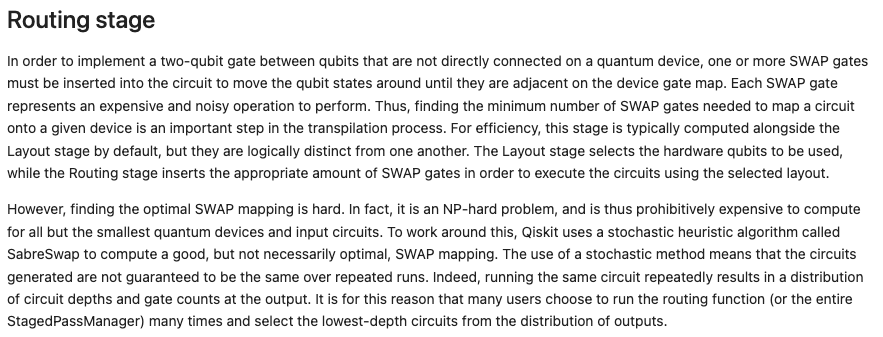

In [56]:
list_stage_plugins("routing")

['basic', 'lookahead', 'none', 'sabre', 'stochastic']

In [57]:
print("Number of each gates of transpiled circuit and the score")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score:.6f}")

Number of each gates of transpiled circuit and the score

Optimization level 0:
rz : 406
sx : 192
cz : 81
x : 1
Score: 0.443191

Optimization level 1:
rz : 167
sx : 95
cz : 48
Score: 0.133092

Optimization level 2:
sx : 95
rz : 90
cz : 48
Score: 0.133092

Optimization level 3:
sx : 92
rz : 79
cz : 42
x : 1
Score: 0.121427


Plugins run by basic routing stage

Optimization level 0:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap


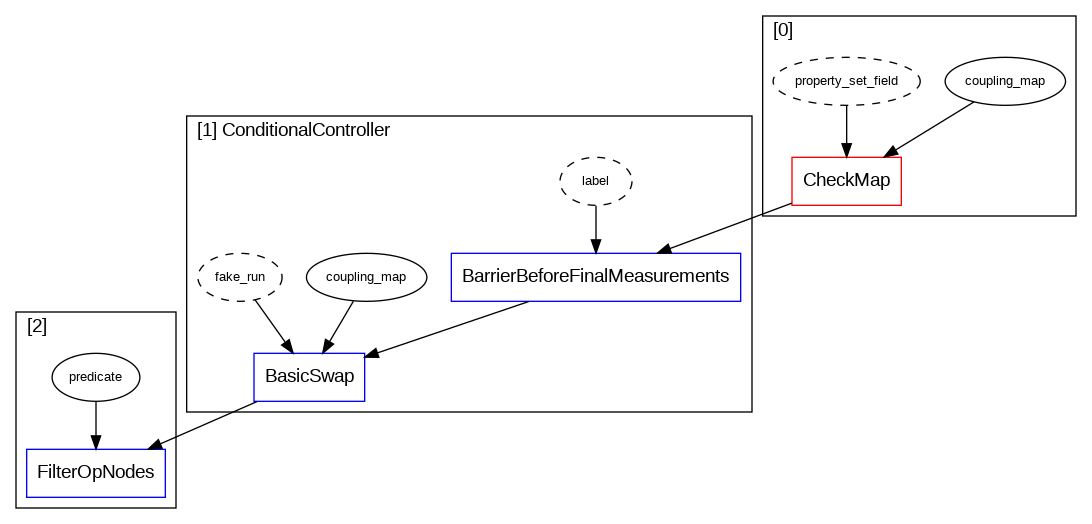

[4, 1, 2, 0, 5, 3]

Optimization level 1:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout


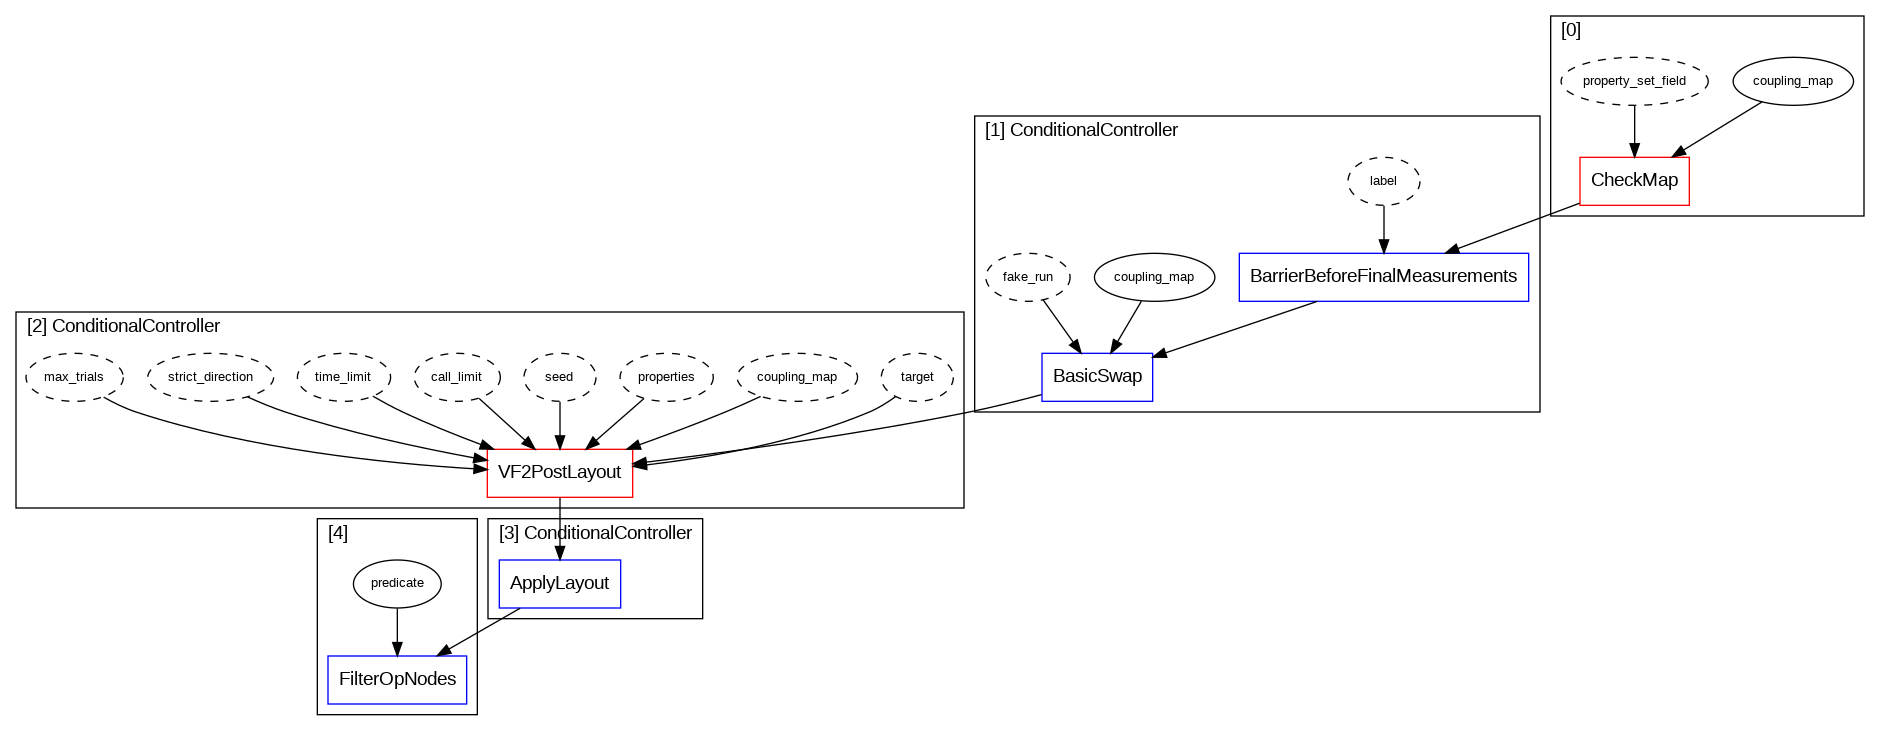

[99, 110, 97, 96, 92, 98]

Optimization level 2:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout


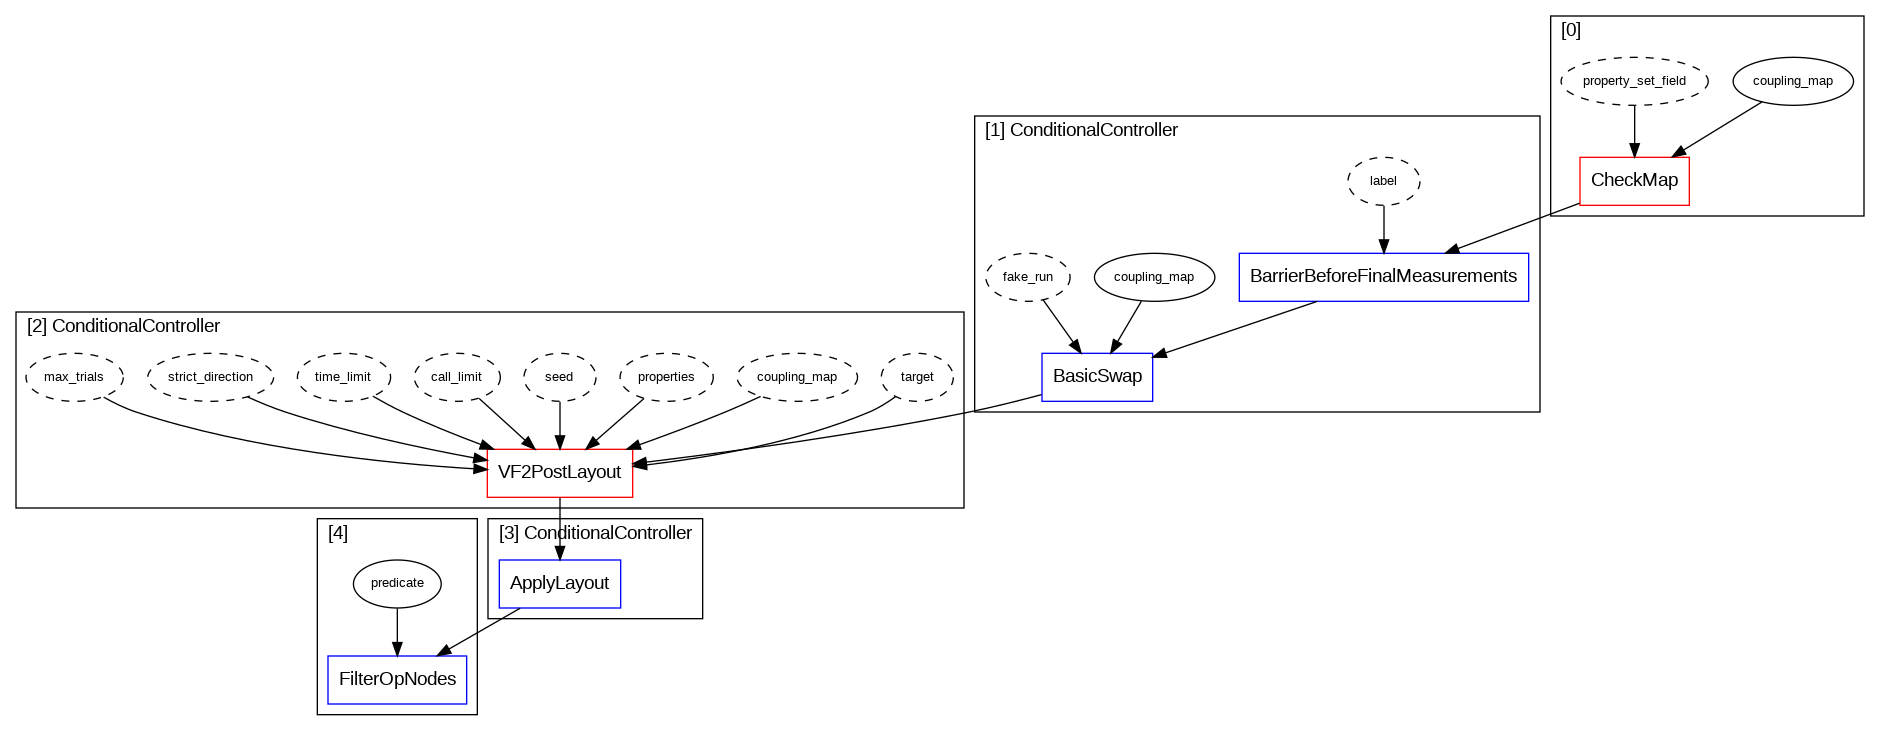

[99, 110, 97, 96, 92, 98]

Optimization level 3:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout


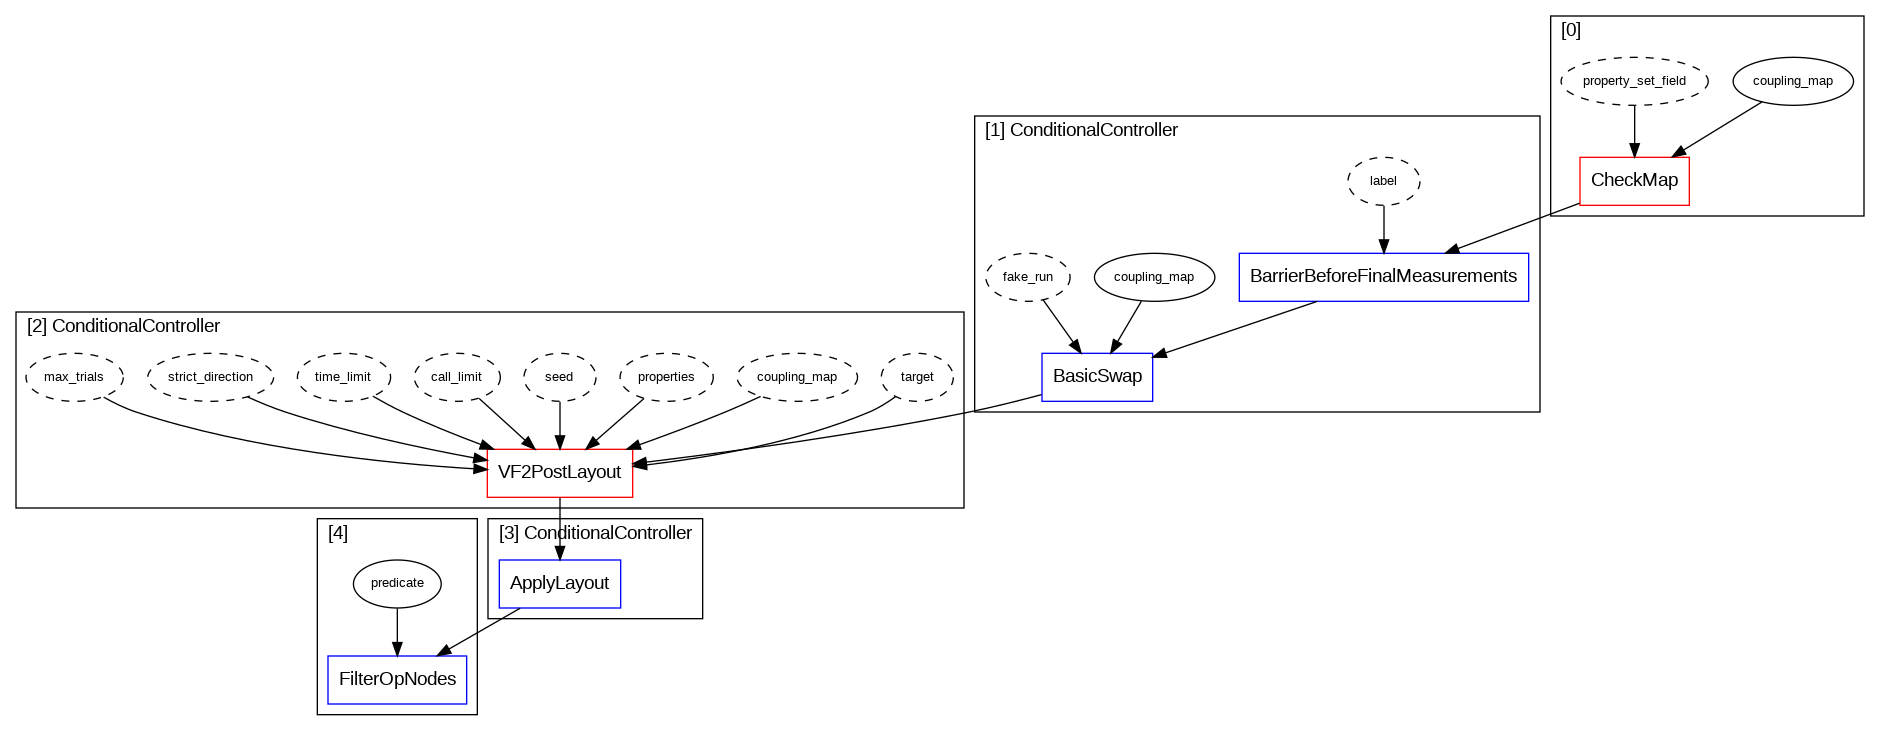

[99, 110, 97, 96, 92, 98]


In [58]:
print("Plugins run by basic routing stage")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)

    for controller_group in pm.routing.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:
            print(" - " , str(type(task).__name__))
    display(pm.routing.draw())
    print(pm.run(qc).layout.final_index_layout())

In [59]:
## process stopped due to lookahead
options = ['basic','sabre', 'stochastic']

for option in options:
    print(f"Layout option = {option}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, routing_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)

    print(f"Score: {score:.6f}")

    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print("\n")

Layout option = basic:
Score: 0.121427
sx : 92
rz : 79
cz : 42
x : 1


Layout option = sabre:
Score: 0.096126
sx : 74
rz : 65
cz : 37
x : 1


Layout option = stochastic:
Score: 0.169540
sx : 137
rz : 108
cz : 66




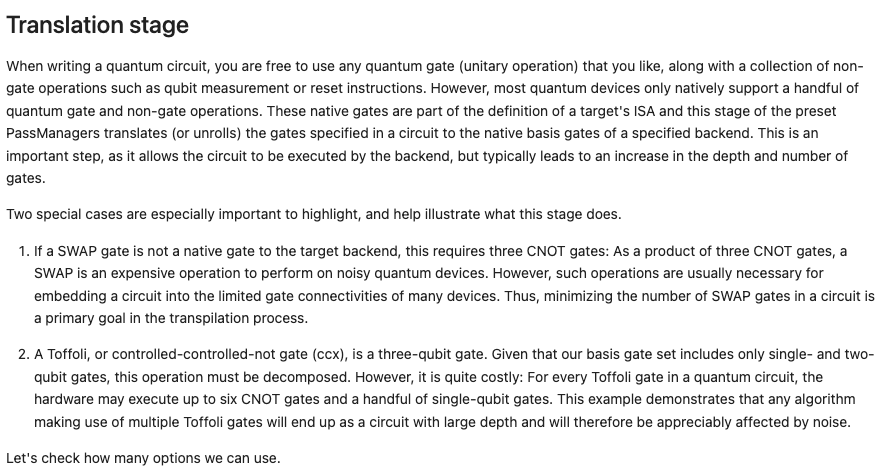

In [61]:
list_stage_plugins("translation")

['synthesis', 'translator', 'ibm_backend', 'ibm_dynamic_circuits']

In [62]:
# The basic options in Qiskit are 'translator' and 'synthesis'.
# Let's count the total gate numbers, circuit depth, and scores of transpiled circuits with the default option ('translator') and each optimization level.

print("Number of each gates of transpiled circuit")
print("=================================")

for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method='translator', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score:.6f}")

Number of each gates of transpiled circuit

Optimization level 0:
rz : 394
sx : 186
cz : 78
x : 1
Score: 0.378009

Optimization level 1:
rz : 131
sx : 77
cz : 39
Score: 0.100534

Optimization level 2:
sx : 77
rz : 71
cz : 39
Score: 0.100534

Optimization level 3:
sx : 74
rz : 65
cz : 37
x : 1
Score: 0.096126


In [63]:
options = ['translator', 'synthesis']

print("Number of each gates of transpiled circuit")
print("=================================")

for option in options:
    print(f"Layout option = {option}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, translation_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score:.6f}")
    print("\n")

Number of each gates of transpiled circuit
Layout option = translator:
sx : 74
rz : 65
cz : 37
x : 1
Score: 0.096126


Layout option = synthesis:
sx : 73
rz : 70
cz : 37
x : 12
Score: 0.099269




In [64]:
# Let's plot it on a graph.

tr_depths = []
tr_gate_counts = []
tr_scores = []

options = ['translator', 'synthesis']

for i in range(4):
    for option in options:
        pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method=option, seed_transpiler=seed)

        tr_depths.append(pm.run(qc).depth())
        tr_gate_counts.append(sum(pm.run(qc).count_ops().values()))
        tr_scores.append(scoring(pm.run(qc), backend))

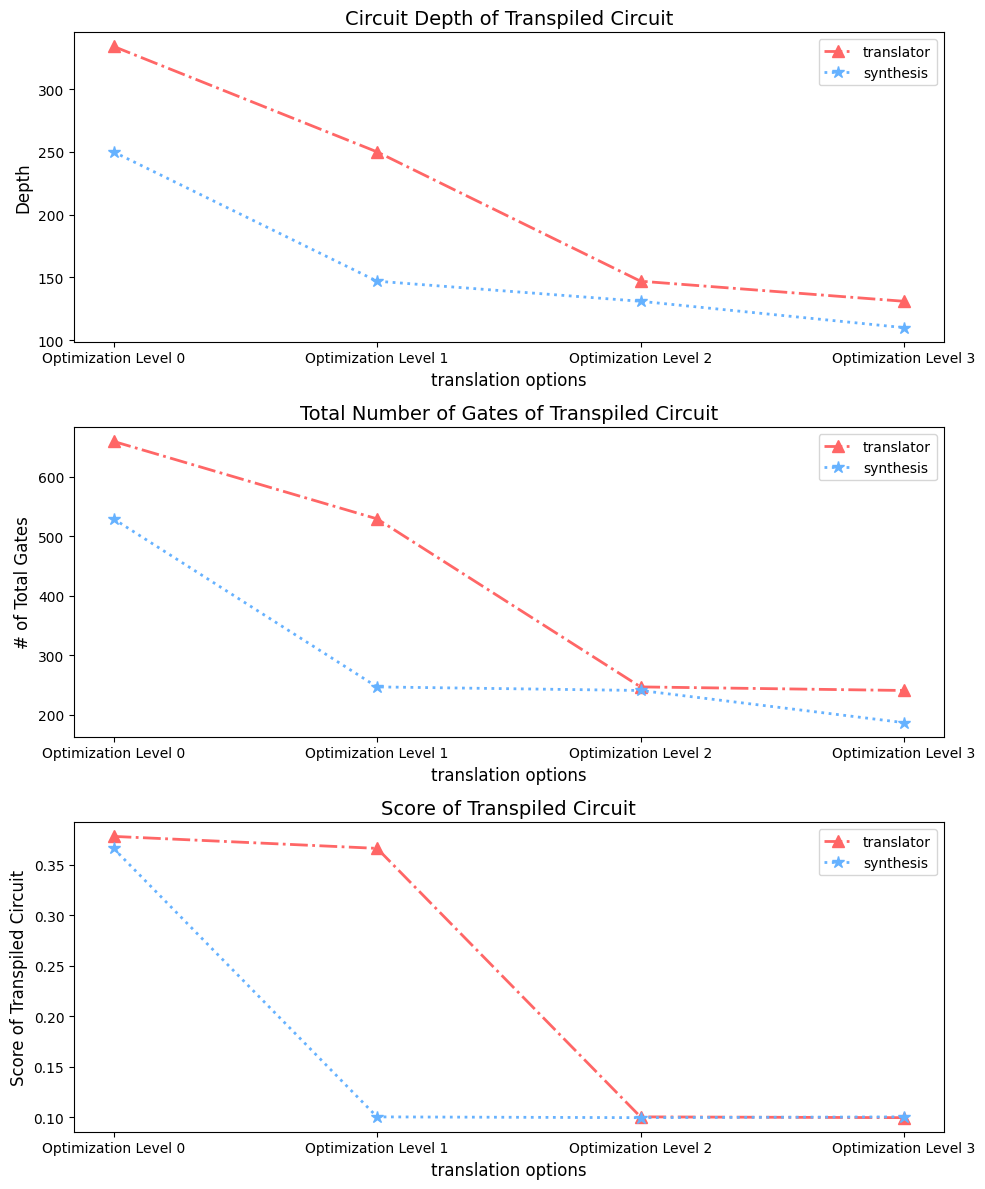

In [65]:
colors = ['#FF6666', '#66B2FF']
markers = [ '^', '*']
linestyles = ['-.', ':']

opt_list = []
for i in range(4):
    opt_list.append(f"Optimization Level {i}")

ax = opt_list
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
for i in range(2):
    ax1.plot(ax, tr_depths[i:i+4], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("translation options", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(2):
    ax2.plot(ax, tr_gate_counts[i:i+4], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("translation options", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
for i in range(2):
    ax3.plot(ax, tr_scores[i:i+4], label=options[i], marker=markers[i],markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("translation options", fontsize=12)
ax3.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax3.set_title("Score of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

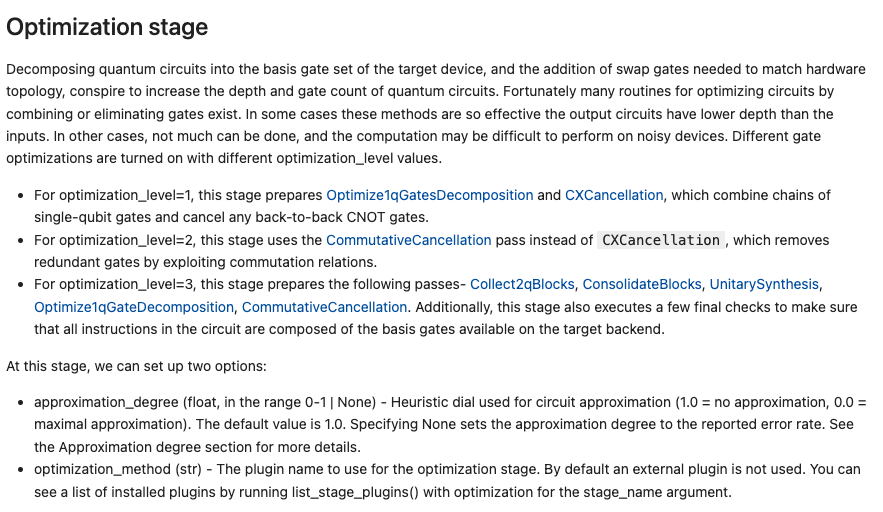

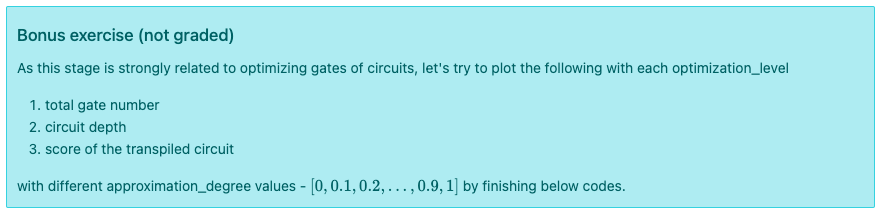

In [71]:
tr_depths = []
tr_gate_counts = []
tr_scores = []

approximation_degree_list = np.linspace(0, 1, 10)

for i in range(4):
    depths = []
    gate_counts = []
    scores = []

    for j in approximation_degree_list:
        # transpiled_circuit = transpile(qc, backend, optimization_level=i, approximation_degree=j)
        passManager = generate_preset_pass_manager(backend=backend, optimization_level=i,approximation_degree=j,seed_transpiler=seed)

        circuit = passManager.run(qc)

        # Calculate circuit depth
        depth = circuit.depth()
        depths.append(depth)

        # Calculate total gate count
        gate_count = sum(dict(circuit.count_ops()).values())
        gate_counts.append(gate_count)

        # Calculate circuit score
        score = scoring(circuit, backend)
        scores.append(score)
        # print(scores,depths)
    tr_depths.append(depths)
    tr_gate_counts.append(gate_counts)
    tr_scores.append(scores)


[0.378009145088254] [334]
[0.378009145088254, 0.378009145088254] [334, 334]
[0.378009145088254, 0.378009145088254, 0.378009145088254] [334, 334, 334]
[0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254] [334, 334, 334, 334]
[0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254] [334, 334, 334, 334, 334]
[0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254] [334, 334, 334, 334, 334, 334]
[0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254] [334, 334, 334, 334, 334, 334, 334]
[0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254] [334, 334, 334, 334, 334, 334, 334, 334]
[0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378009145088254, 0.378

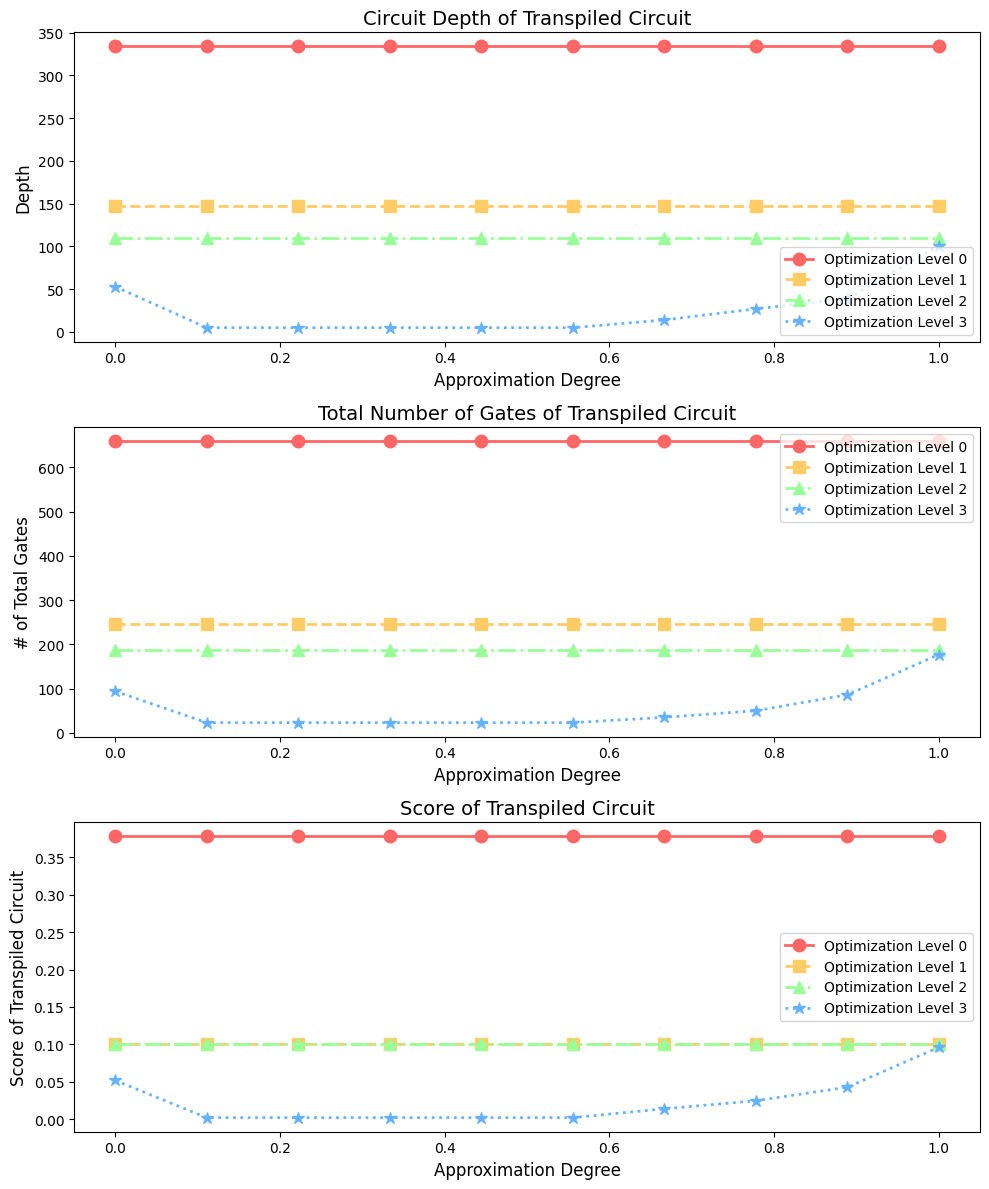

In [74]:
tr_depths = []
tr_gate_counts = []
tr_scores = []

approximation_degree_list = np.linspace(0, 1, 10)

for i in range(4):
    depths = []
    gate_counts = []
    scores = []

    for j in approximation_degree_list:
        # transpiled_circuit = transpile(qc, backend, optimization_level=i, approximation_degree=j)
        passManager = generate_preset_pass_manager(backend=backend, optimization_level=i, approximation_degree=j, seed_transpiler=seed)
        circuit = passManager.run(qc)

        # Calculate circuit depth
        depth = circuit.depth()
        depths.append(depth)

        # Calculate total gate count
        gate_count = sum(dict(circuit.count_ops()).values())
        gate_counts.append(gate_count)

        # Calculate circuit score
        score = scoring(circuit, backend)
        scores.append(score)

    tr_depths.append(depths)
    tr_gate_counts.append(gate_counts)
    tr_scores.append(scores)


colors = ['#FF6666', '#FFCC66', '#99FF99', '#66B2FF']
markers = ['o', 's', '^', '*']
linestyles = ['-', '--', '-.', ':']

ax = approximation_degree_list
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
for i in range(4):
    ax1.plot(ax, tr_depths[i], label=f"Optimization Level {i}", marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("Approximation Degree", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(4):
    ax2.plot(ax, tr_gate_counts[i], label=f"Optimization Level {i}", marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("Approximation Degree", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
for i in range(4):
    ax3.plot(ax, tr_scores[i], label=f"Optimization Level {i}", marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("Approximation Degree", fontsize=12)
ax3.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax3.set_title("Score of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()


# Scheduling stage
This last stage is only run if it is explicitly called for (similar to the init stage) and does not run by default (though a method can be specified by setting the 1scheduling_method1 argument when calling generate_preset_pass_manager). The scheduling stage is typically used once the circuit has been translated to the target basis, mapped to the device, and optimized. These passes focus on accounting for all the idle time in a circuit. At a high level, the scheduling pass can be thought of as explicitly inserting delay instructions to account for the idle time between gate executions and to inspect how long the circuit will be running on the backend.

First, let'sc check which options we can use.

In [75]:
list_stage_plugins("scheduling")

['alap', 'asap', 'default']

In [76]:
# To use scheduling options, let's first prepare timing_constraints, which contains relevant information about the backend to get the optimized pulse schedule.

backend_timing = backend.target.timing_constraints()
timing_constraints = TimingConstraints(
    granularity=backend_timing.granularity,
    min_length=backend_timing.min_length,
    pulse_alignment=backend_timing.pulse_alignment,
    acquire_alignment=backend_timing.acquire_alignment )

In [77]:
# Run with optimization level 3 and 'asap' scheduling pass
pm_asap = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    timing_constraints=timing_constraints,
    scheduling_method="asap",
    seed_transpiler=seed,
)

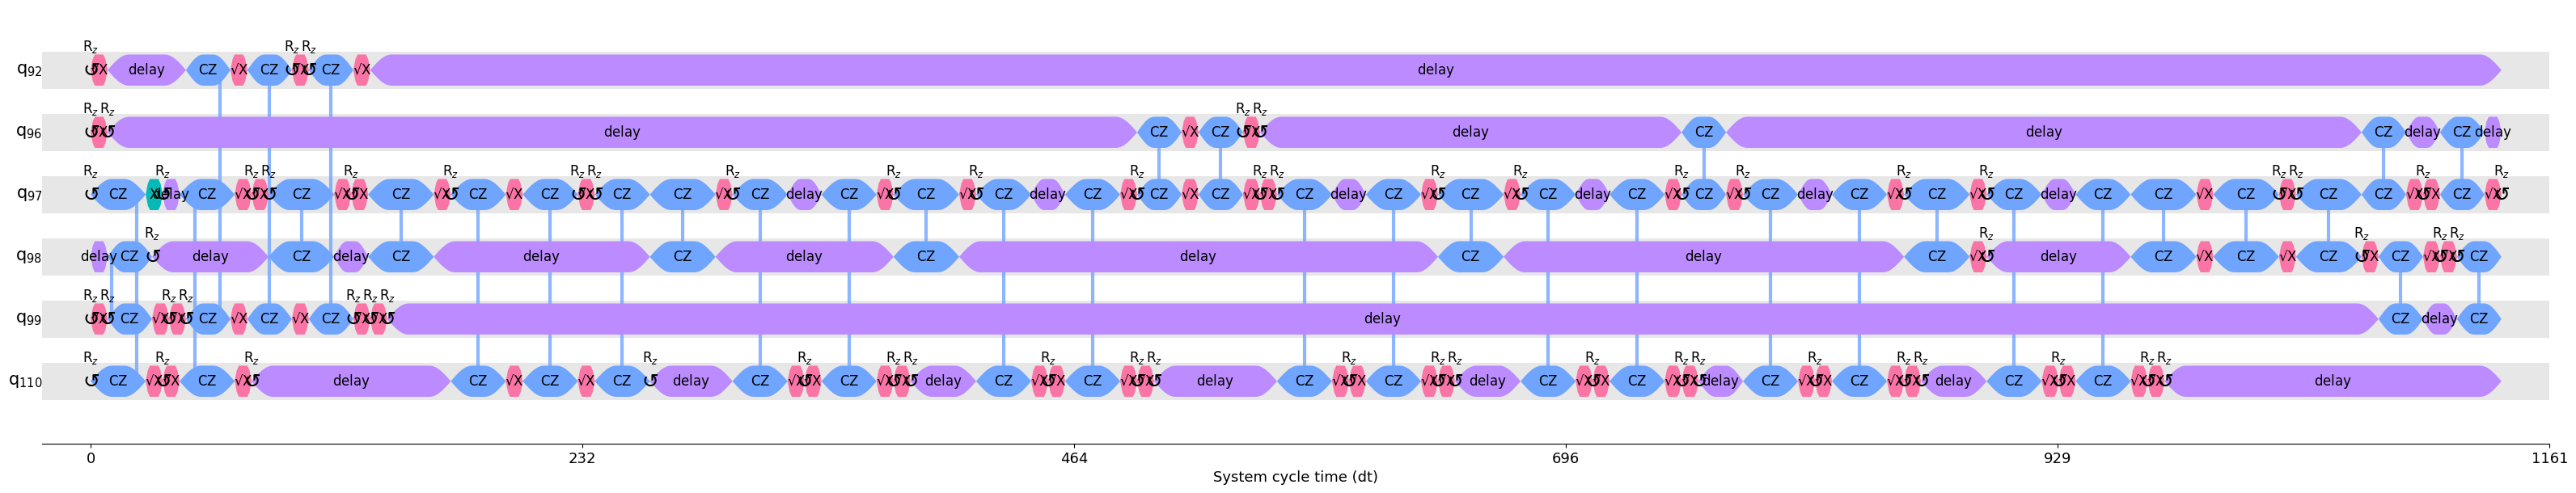

In [78]:
my_style = {
    'formatter.general.fig_width': 40,
    'formatter.general.fig_unit_height': 1,
}

draw(pm_asap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

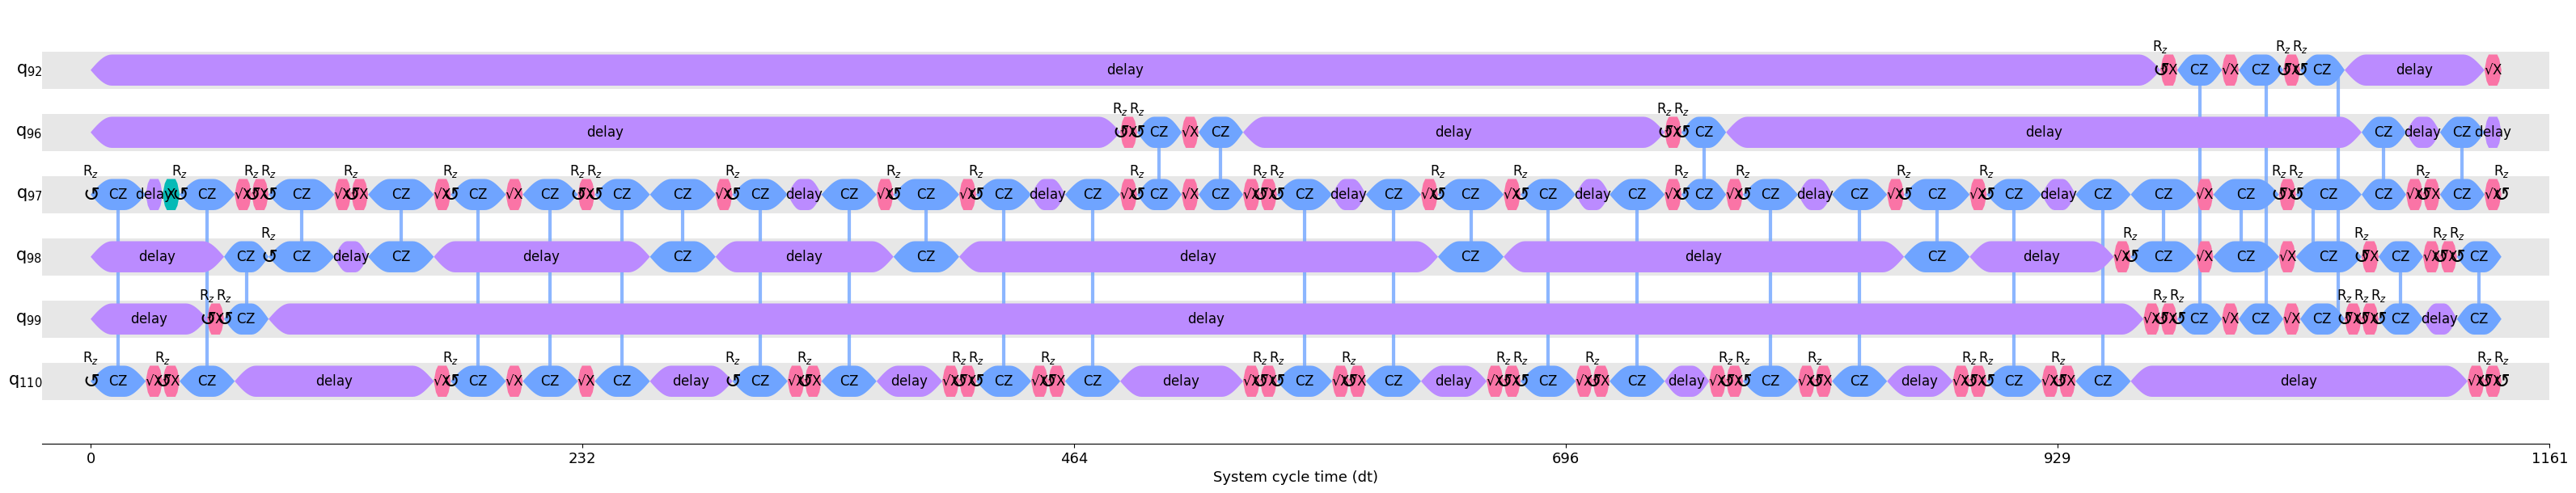

In [79]:
pm_alap = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    timing_constraints=timing_constraints,
    scheduling_method="alap",
    seed_transpiler=seed,
)
draw(pm_alap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

In [85]:
print("Score")
print("===============")

print(f"asap: {scoring(pm_asap.run(qc), backend):.6f}")
print(f"alap: {scoring(pm_alap.run(qc), backend):.6f}")

Score


NameError: name 'qubit_error' is not defined

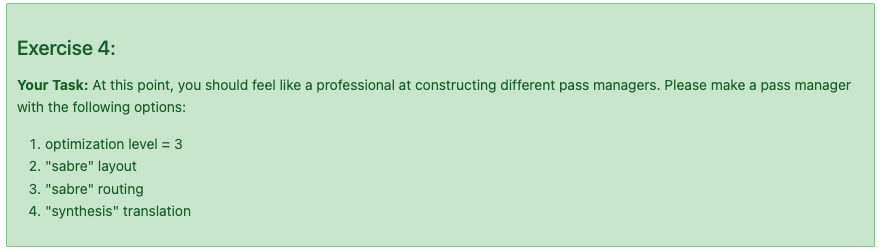

In [90]:
pm_ex4 = generate_preset_pass_manager(
    backend=backend,
    optimization_level=3,
    timing_constraints=timing_constraints,
    seed_transpiler=seed,
    layout_method="sabre",
    routing_method="sabre",
    translation_method="synthesis"
)

In [91]:
# Submit your answer using following code

grade_lab2_ex4(pm_ex4)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


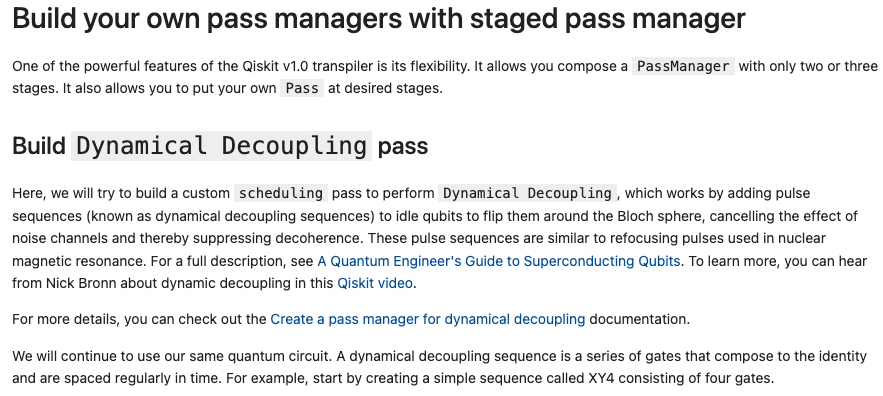

In [92]:
X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

Because of the regular timing of dynamical decoupling sequences, information about the YGate must be added to the target because it is not a basis gate, whereas the XGate is. We know a priori that the YGate has the same duration and error as the XGate, however, so we can just retrieve those properties from the target and add them back for the YGate. This is also why the basis_gates were saved separately, since we are adding the YGate instruction to the target, although it is not an actual basis gate of ou

In [93]:
backend=FakeTorino()

target = backend.target

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

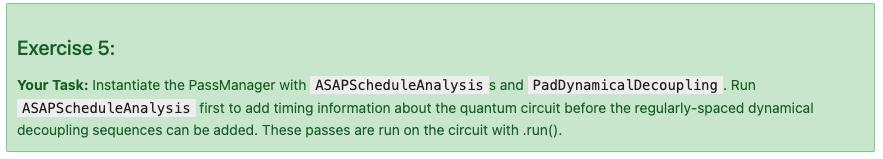

In [95]:
dd_pm = PassManager(
    [
        ASAPScheduleAnalysis(),
        PadDynamicalDecoupling(dd_sequence=dd_sequence)
    ]
)

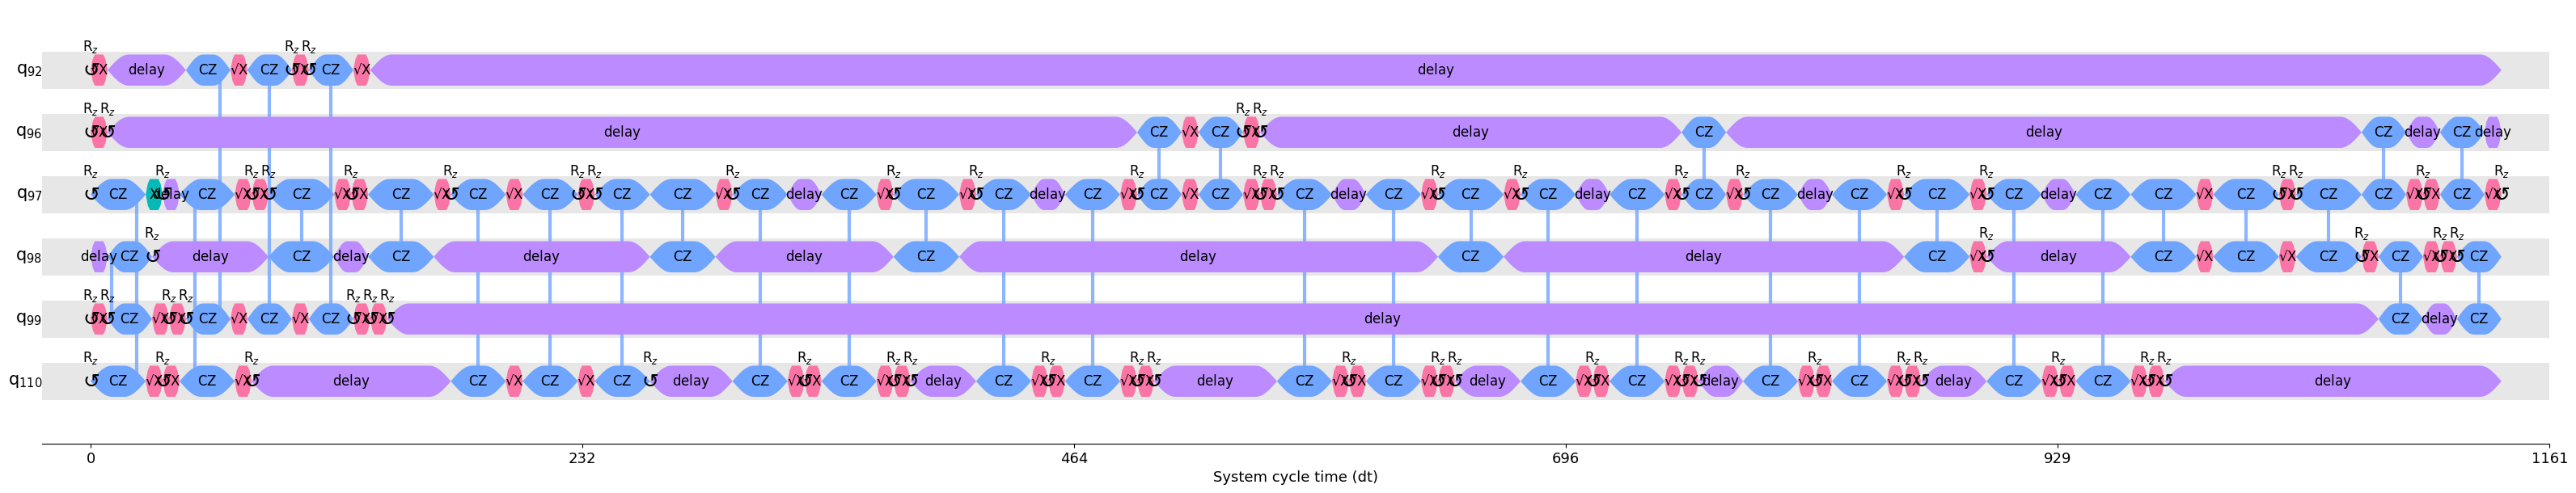

In [96]:
# Now let's see how it works by comparing it with a Timing of asap scheduling option. First, let's bring the timing drawing from above.

draw(pm_asap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

In [99]:
# Now, let's make a custom scheduling Pass by using the function we've created.
# For this new scheduling pass we will use StagedPassManager. We can make a PassManager that only has one pass. After making a custom staged PassManager, we will apply this to the transpiled circuit with pm_asap, that we already created above.

staged_pm_dd = StagedPassManager(
    stages=["scheduling"],
    scheduling=dd_pm
)


In [105]:
qc_tr = pm_asap.run(qc)
# draw(staged_pm_dd.run(qc_tr), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

In [101]:
# Submit your answer using following code

grade_lab2_ex5(staged_pm_dd)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
